This is a notebook demonstrating directional spread issues as measured from acoustic instruments.  The problem specifically arises when doing half-planed comparisons which are comparisons using only the shorewardly incident energy (eg between -18 and 162 degrees true North --at the FRF).  The mean direction problems documented are a symptom as documented by Herbers in 2009
https://journals.ametsoc.org/doi/pdf/10.1175/2009JTECHO681.1

In [34]:
%matplotlib inline
import netCDF4 as nc
import numpy as np
import datetime as DT
import sys, pickle
sys.path.append('/home/spike/repos')
from testbedutils import sblib as sb
from getdatatestbed import getDataFRF
from testbedutils import waveLib as wl
sys.path.append('/home/spike/cmtb')
# from plotting.nonoperationalPlots import plot_scatterAndQQ
import researchLib as RL
from matplotlib import pyplot as plt 
from matplotlib.colors import LogNorm

##################################################################
start = DT.datetime(2009, 1, 1)
end = DT.datetime(2011, 1, 1) #2009, 9, 15)
IGcutoff = 1/20.  # frequency for infragravity cut off
HFcutoff = 1/4.   # high frequency cutoff -- set by 11m AWAC depth

# Get Observations  and model data

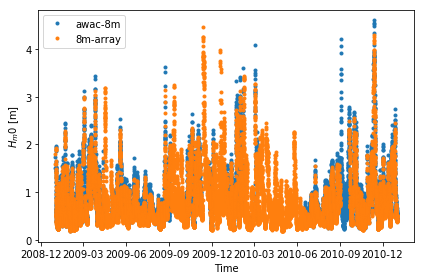

In [35]:
server = 'FRF'
gauge = 'awac-8m'                     # set gauges for comparison
modlabel = '8m-array'                 # set 8m array for mod-label
obslabel = gauge                      # which gauge to use as obslabel

go = getDataFRF.getObs(start, end, THREDDS=server)
mod = go.getWaveSpec('8m-array', removeBadDataFlag=3, ab=True)
obs = go.getWaveSpec(gauge, removeBadDataFlag=3, ab=True)
HPspecs, HPdirs = wl.HPchop_spec(obs['dWED'], obs['wavedirbin'], angadj=72)

#gm = getDataFRF.getDataTestBed(start, end)
#gm.getWaveSpecModel('HP', '8m-array', model='STWAVE')
# plt.subplot(121)

plt.plot(obs['time'], obs['Hs'], '.', label=obslabel)   
plt.plot(mod['time'], mod['Hs'], '.', label=modlabel)
plt.ylabel('$H_m0$ [m]')
plt.xlabel('Time')
plt.legend()
# plt.subplot(122)
# plt.plot(obs['time'], obs['waveDm'], '.')   
# plt.plot(mod['time'], mod['waveDm'], '.')
plt.tight_layout()
# obs.keys()

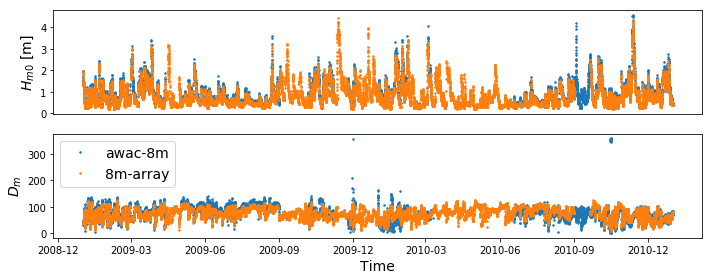

In [92]:
fsize=14
msize= 3
plt.figure(figsize=(10,4))
plt.subplot(211)
plt.plot(obs['time'], obs['Hs'], '.', label=obslabel, ms=msize)   
plt.plot(mod['time'], mod['Hs'], '.', label=modlabel, ms=msize)
plt.ylabel('$H_{m0}$ [m]', fontsize=fsize)
# plt.xlabel('Time', fontsize=fsize)
plt.tick_params(axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)

plt.subplot(212)
plt.plot(obs['time'], obs['waveDm'], '.', label=obslabel, ms=msize)   
plt.plot(mod['time'], mod['waveDm'], '.', label=modlabel, ms=msize)
plt.ylabel('$D_m$', fontsize=fsize)
plt.xlabel('Time', fontsize=fsize)
plt.legend(fontsize=fsize)
plt.tight_layout()
# obs.keys()

# Now time match, calculate statistics and create halfplaned data to start comparisons


In [3]:
#first time match 
matchedTime, idxobs, idxmod = sb.timeMatch(obs_time=obs['time'], obs_data=None, model_time=mod['time'], model_data=None)
mod_matched = sb.reduceDict(mod, idxmod)
obs_matched = sb.reduceDict(obs, idxobs)
# print(mod_matched.keys())
# calculate stats  for Full plane 
mod_bulkStat_FP = wl.waveStat(mod_matched['dWED'], mod_matched['wavefreqbin'], mod_matched['wavedirbin'],lowFreq= IGcutoff, highFreq=HFcutoff)
obs_bulkStat_FP = wl.waveStat(obs_matched['dWED'], obs_matched['wavefreqbin'], obs_matched['wavedirbin'],lowFreq=IGcutoff, highFreq=HFcutoff)
# print(mod_matched.keys())
# now Half plane 
mod_bulkStat_HP = RL.replaceWaveDictHalfPlaneSpectralStats(mod_matched.copy(), freqLims=(IGcutoff, HFcutoff))
obs_bulkStat_HP = RL.replaceWaveDictHalfPlaneSpectralStats(obs_matched.copy(), freqLims=(IGcutoff, HFcutoff))
# print(mod_matched.keys())

In [4]:
# find frequencies of interest based on set limits 
idxFreq = np.argwhere((mod_matched['wavefreqbin'] <= HFcutoff) & (mod_matched['wavefreqbin']> IGcutoff)).squeeze() 

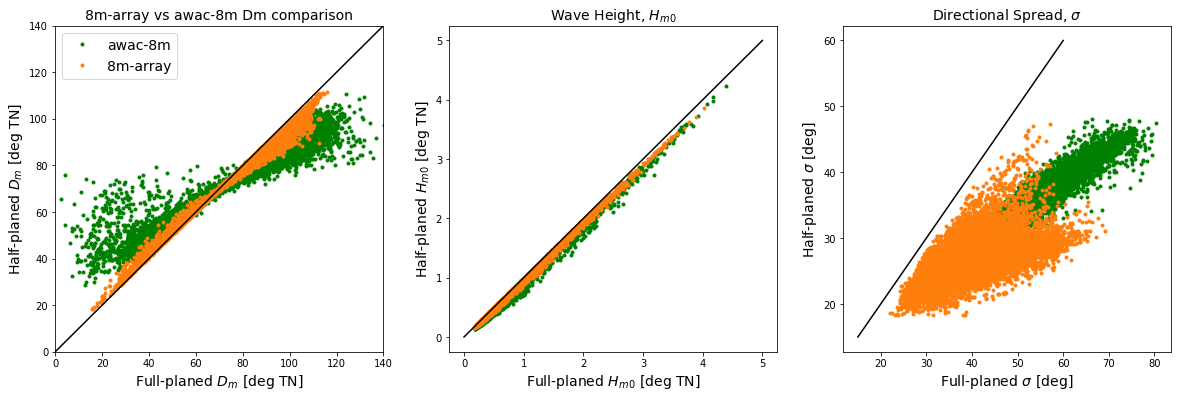

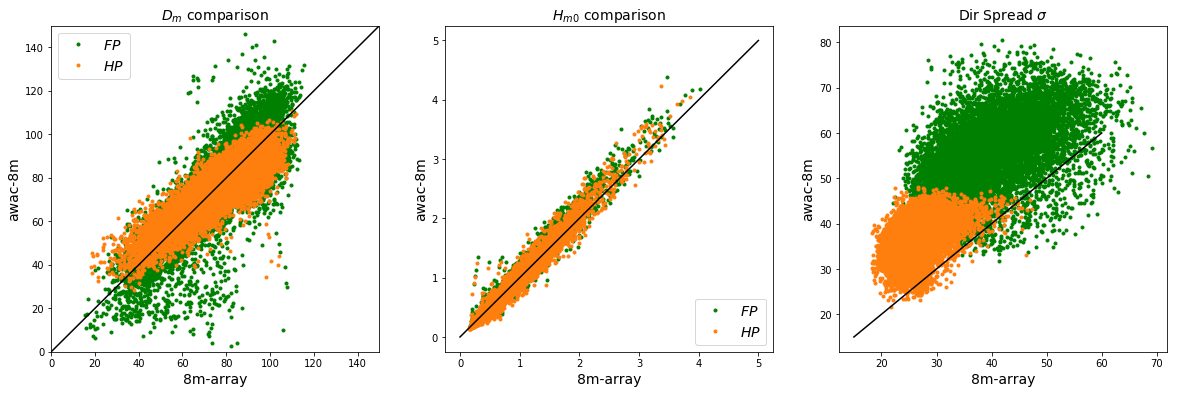

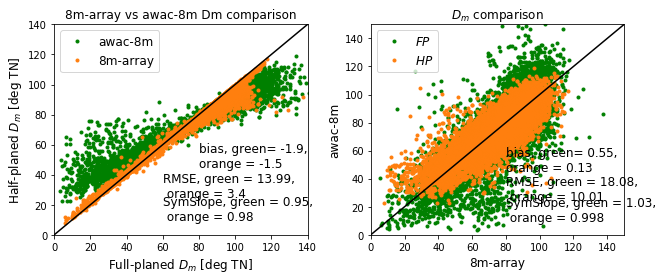

In [45]:
fsize=14
plt.figure(figsize=(20,6))
plt.subplot(131)
stat = 'Dm'
g_stat = sb.statsBryant(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat])
o_stat = sb.statsBryant(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat])
plt.title('8m-array vs {} Dm comparison'.format(gauge), fontsize=fsize)
plt.plot(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat], 'g.', label=obslabel)
plt.plot(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat], 'C1.', label=modlabel)
plt.plot([0,180], [0, 180], 'k-')
# plt.text(80,45, 'bias, green= {:.2},\norange = {:.2}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
# plt.text(60,25, 'RMSE, green = {:.2f},\n orange = {:.2}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
# plt.text(60,10,'SymSlope, green = {:.2},\n orange = {:.2}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.ylabel('Half-planed $D_m$ [deg TN]', fontsize=fsize)
plt.xlabel('Full-planed $D_m$ [deg TN]', fontsize=fsize)
plt.xlim([0,140])
plt.ylim([0, 140])
plt.legend(fontsize=fsize)

plt.subplot(132)
stat='Hm0'
g_stat = sb.statsBryant(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat])
o_stat = sb.statsBryant(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat])
plt.plot(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat], 'g.', label=obslabel)
plt.plot(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat], 'C1.', label=modlabel)
plt.plot([0,5], [0, 5], 'k-')
# plt.text(0, 4.5, 'bias, green = {:.2f}\n orange = {:.2f}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
# plt.text(0, 3.5, 'RMSE, green  = {:.2f}\n orange = {:.2f}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
# plt.text(0, 2.5, 'SymSlope, green = {:.3}\n orange = {:.3}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.title('Wave Height, $H_{m0}$', fontsize=fsize)
plt.ylabel('Half-planed $H_{m0}$ [deg TN]', fontsize=fsize)
plt.xlabel('Full-planed $H_{m0}$ [deg TN]', fontsize=fsize)

plt.subplot(133)
stat='spreadD'
g_stat = sb.statsBryant(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat])
o_stat = sb.statsBryant(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat])
plt.plot(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat], 'g.', label=obslabel)
plt.plot(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat], 'C1.', label=modlabel)
# plt.text(20.5, 45, 'bias, green = {:.2f}\norange = {:.2f}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
# plt.text(60.5, 40, 'RMSE, green  = {:.2f}\n orange = {:.2f}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
# plt.text(60.5, 20, 'SymSlope, green = {:.3}\n orange = {:.3}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.plot([15,60], [15, 60], 'k-')
plt.title('Directional Spread, $\sigma$', fontsize=fsize)
plt.ylabel('Half-planed $\sigma$ [deg]', fontsize=fsize)
plt.xlabel('Full-planed $\sigma$ [deg]', fontsize=fsize)
#################################################################################
## awac vs array 
plt.figure(figsize=(20, 6))
ax2 = plt.subplot(131)
stat = 'Dm'
g_stat = sb.statsBryant(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat])
o_stat = sb.statsBryant(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat])
ax2.plot(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat], 'g.', label='$FP$')
ax2.plot(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat], 'C1.', label='$HP$')
ax2.set_ylabel(obslabel, fontsize=fsize)
ax2.set_xlabel(modlabel, fontsize=fsize)
# plt.text(80, 45, 'bias, green= {:.2f},\norange = {:.2f}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
# plt.text(80,25, 'RMSE, green = {:.2f},\n orange = {:.2f}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
# plt.text(80,10,'SymSlope, green = {:.3},\n orange = {:.3}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.plot([0,150], [0, 150], 'k-')
ax2.set_ylim([0, 150])
ax2.set_xlim([0, 150])
ax2.legend(fontsize=fsize, loc='upper left')
ax2.set_title('$D_m$ comparison', fontsize=fsize)

ax1 = plt.subplot(132)
stat='Hm0'
g_stat = sb.statsBryant(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat])
o_stat = sb.statsBryant(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat])

ax1.plot(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat], 'g.', label='$FP$')
ax1.plot(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat], 'C1.', label='$HP$')
ax1.set_ylabel(obslabel, fontsize=fsize)
ax1.set_xlabel(modlabel, fontsize=fsize)
# plt.text(0, 4.5, 'bias, green = {:.2f}\n orange = {:.2f}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
# plt.text(0, 3.5, 'RMSE, green  = {:.2f}\n orange = {:.2f}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
# plt.text(2.2, 1, 'SymSlope, green = {:.3}\n orange = {:.3}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.plot([0,5], [0, 5], 'k-')
ax1.set_title('$H_{m0}$ comparison', fontsize=fsize)
ax1.legend(fontsize=fsize,loc='lower right')


ax3 = plt.subplot(133)
stat='spreadD'
g_stat = sb.statsBryant(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat])
o_stat = sb.statsBryant(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat])
ax3.plot(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat], 'g.', label='$FP$')
ax3.plot(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat], 'C1.', label='$HP$')

# plt.text(20, 75, 'bias, green = {:.2f}\norange = {:.2f}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
# plt.text(20, 68, 'RMSE, green  = {:.2f}\n orange = {:.2f}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
# plt.text(40., 20, 'SymSlope, green = {:.5}\n orange = {:.5}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.plot([15, 60], [15, 60], 'k-')
ax3.set_ylabel(obslabel, fontsize=fsize)
ax3.set_xlabel(modlabel, fontsize=fsize)
ax3.set_title(r'Dir Spread $\sigma$', fontsize=fsize)
#################################################################3
fsize=12
stat = 'Dm_p4'   # power 4 mean direction 
g_stat = sb.statsBryant(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat])
o_stat = sb.statsBryant(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat])

plt.figure(figsize=(9, 4))
ax1 = plt.subplot(121)
plt.title('8m-array vs {} Dm comparison'.format(gauge), fontsize=fsize)
plt.plot(obs_bulkStat_FP[stat], obs_bulkStat_HP[stat], 'g.', label=obslabel)
plt.plot(mod_bulkStat_FP[stat], mod_bulkStat_HP[stat], 'C1.', label=modlabel)
plt.plot([0,180], [0, 180], 'k-')
plt.text(80,45, 'bias, green= {:.2},\norange = {:.2}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
plt.text(60,25, 'RMSE, green = {:.2f},\n orange = {:.2}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
plt.text(60,10,'SymSlope, green = {:.2},\n orange = {:.2}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.ylabel('Half-planed $D_m$ [deg TN]', fontsize=fsize)
plt.xlabel('Full-planed $D_m$ [deg TN]', fontsize=fsize)
plt.xlim([0,140])
plt.ylim([0, 140])
plt.legend(fontsize=fsize)

g_stat = sb.statsBryant(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat])
o_stat = sb.statsBryant(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat])
ax2 = plt.subplot(122)
ax2.plot(mod_bulkStat_FP[stat], obs_bulkStat_FP[stat], 'g.', label='$FP$')
ax2.plot(mod_bulkStat_HP[stat], obs_bulkStat_HP[stat], 'C1.', label='$HP$')
ax2.set_ylabel(obslabel, fontsize=fsize)
ax2.set_xlabel(modlabel, fontsize=fsize)
plt.text(80, 45, 'bias, green= {:.2f},\norange = {:.2f}'.format(g_stat['bias'], o_stat['bias']), fontsize=fsize)
plt.text(80,25, 'RMSE, green = {:.2f},\n orange = {:.2f}'.format(g_stat['RMSE'], o_stat['RMSE']), fontsize=fsize)
plt.text(80,10,'SymSlope, green = {:.3},\n orange = {:.3}'.format(g_stat['symSlope'], o_stat['symSlope']), fontsize=fsize)
plt.plot([0,150], [0, 150], 'k-')
ax2.set_ylim([0, 150])
ax2.set_xlim([0, 150])
ax2.legend(fontsize=fsize, loc='upper left')
ax2.set_title('$D_m$ comparison', fontsize=fsize)
plt.tight_layout()

Interesting to see the last plot on the bottom, seems to stabilize values approaching from the south, but not from the North, I'm not sure what to think about that

The below plots examine the affect of Half-planning the spectra on the bulk statistics for the Mean direction , Dm, the wave height, Hm0, and directional spread, $\sigma$.  The __top plot__ shows the `full plane` data on the x axis and the `half-plane` data on the y-axis. the __bottom plots__ show the `8m-array` on the x-axis and the `8m-AWAC` on the y-axis, with the half and full planned data plotted in orange and blue respectively. 

$D_m$, Mean Direction 

The `half-plane` action shifts the mean direction more shore normal (~72) with the _acoustic_ `8m-AWAC` when compared to the `8m-array` (_top-left and bottom-left plot_).  This becomes a significant problem in the model-data comparison.  The data extremes are much larger for `Half-plane` $D_m$ coming from the `8m-array` than that of the `8m-AWAC`.  Given that the wave energy compares pretty well, this might suggest that directional spreading is a key factor in this directional shift. If there was similar spread, the half-plane comparison would have a similar slope to the full plane. 

$H_s$, Significant Wave Height

 The _bottom-center plot_ shows pretty good agreement between the two instruments in `Full-plane` (RMSE = 11 cm and bias = 8 cm) with the acoustic gauge being slightly under measured compared to the `8m-array` (bias = 9 cm).  The scatter is reduced (RMSE = 12 cm) for `half-planed` comparisons. This shows that the wave height statistic is more similar when only interested in the the shorewardly incident part of the spectrum.  Generally more energy is removed from the spectra when using the 2D spectra from the `8m-AWAC` as compared to the `8m-array` _top-center plot_ which is logical if the directional spread values are larger for the acoustic instrument. 
 
$\sigma$, Directional Spread 

The `Full-plane` directional spread, $\sigma$, values are generally larger than that of `Half-plane` which is to be expected (_top-right and bottom-left plot_).  Generally, as might be expected the `8m-array` has a much more refined directional spread relational pattern to from `half-plane` to `full-plane` _top-right plot_ and is almost half the value in `half-plane` from `full-plane`. On the other-hand the directional relation between directional `half` and `full-plane` on the `8m-AWAC` is much less coherant (as evidenced by larger bias and RMSE than the `8m-array`).

Given the model is forced with a 2D spectral estimate from a wave-rider, which measures a surface time series, the directional spread that is in the model is lower (similar to that of the `8m-array`).  This makes the `Half-plane` comparisons to the `8m-AWAC` analogous to what might be expected in the model-data comparisons.  The shift in $D_m$ becomes an inherent problem in `Halfplane` model-observation comparisons. 


### Now examine as function of wave height and incident angle 

In [23]:
# create residuals between the HP and FP results and isolate the largest residuals
dirResiual_acoustic = obs_bulkStat_FP['Dm'] - obs_bulkStat_HP['Dm'] 
dirResiual_8m = mod_bulkStat_FP['Dm'] - mod_bulkStat_HP['Dm'] 


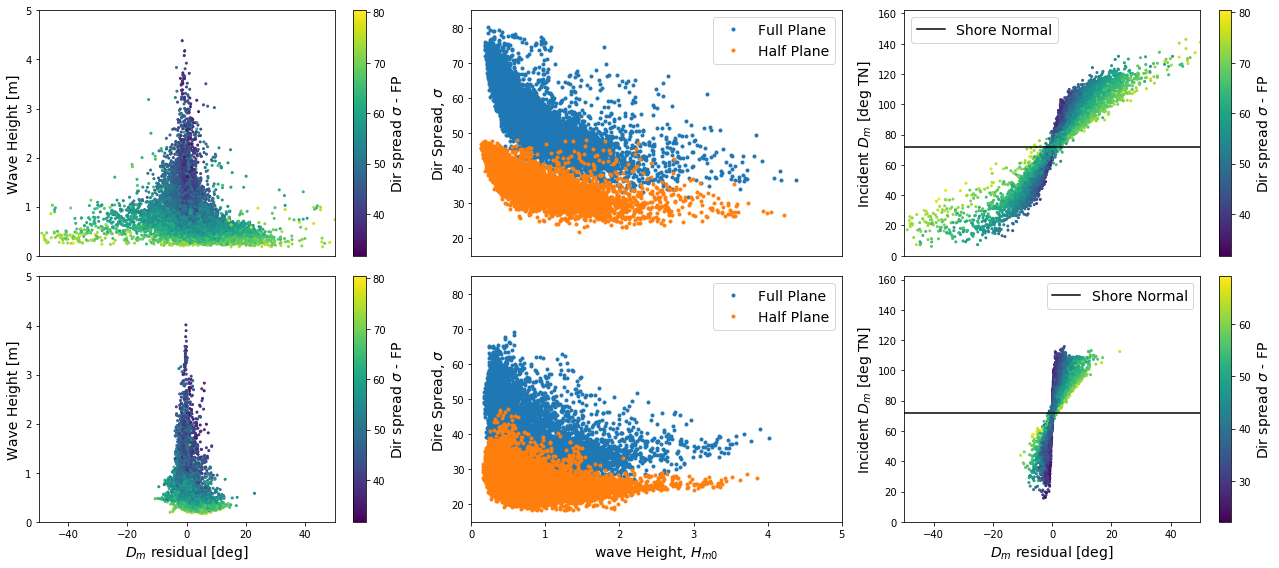

In [73]:
sprdVar = 'spreadD'
fsize=14
########################################
plt.figure(figsize=(18,8))
plt.subplot(231)
cc = plt.scatter(dirResiual_acoustic, obs_bulkStat_FP['Hm0'], c=obs_bulkStat_FP[sprdVar], s=4)
cbar = plt.colorbar(cc)
cbar.set_label('Dir spread $\sigma$ - FP',fontsize=fsize)
plt.ylabel('Wave Height [m]', fontsize=fsize)
# plt.xlabel('$D_m$ residual [deg]'.format(gauge), fontsize=fsize)
# plt.suptitle('{} acoustic gauge'.format(gauge), fontsize=fsize)
plt.xlim([-50, 50])
plt.ylim([0,5])
plt.tick_params(axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)


plt.subplot(232)
plt.plot(obs_bulkStat_FP['Hm0'], obs_bulkStat_FP[sprdVar], '.', label='Full Plane')
plt.plot(obs_bulkStat_HP['Hm0'], obs_bulkStat_HP[sprdVar], '.', label='Half Plane')
plt.legend(fontsize=fsize)
plt.ylim([15,85])
plt.xlim([0,5])
# plt.xlabel('wave height, $H_{m0}$', fontsize=fsize)
plt.ylabel('Dir Spread, $\sigma$'.format(gauge), fontsize=fsize)
plt.tick_params(axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)


plt.subplot(233)
# plt.plot(dirResiual_acoustic, obs_bulkStat_FP['Dm'], '.', label='Full Plane')
cc = plt.scatter(dirResiual_acoustic, obs_bulkStat_FP['Dm'], c=obs_bulkStat_FP[sprdVar], s=4)
cbar = plt.colorbar(cc)
cbar.set_label('Dir spread $\sigma$ - FP',fontsize=fsize)
plt.plot([-50, 50], [72, 72], 'k-', label='Shore Normal')
plt.legend(fontsize=fsize)
plt.xlim([-50, 50]);
plt.ylim([0, 162])
# plt.xlabel('$D_m$ residual [deg] {}'.format(gauge), fontsize=fsize)
plt.ylabel('Incident $D_m$ [deg TN]', fontsize=fsize)
plt.tick_params(axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)
###########################################################################
# plt.figure(figsize=(18, 4))
plt.subplot(234)
cc = plt.scatter(dirResiual_8m, mod_bulkStat_FP['Hm0'], c=obs_bulkStat_FP[sprdVar], s=4)
cbar = plt.colorbar(cc)
cbar.set_label('Dir spread $\sigma$ - FP',fontsize=fsize)
plt.ylabel('Wave Height [m]', fontsize=fsize)
plt.xlabel('$D_m$ residual [deg]'.format(gauge), fontsize=fsize)
# plt.suptitle('{} gauge'.format(modlabel), fontsize=fsize)
plt.xlim([-50, 50])
plt.ylim([0,5])

plt.subplot(235)
plt.plot(mod_bulkStat_FP['Hm0'], mod_bulkStat_FP[sprdVar], '.', label='Full Plane')
plt.plot(mod_bulkStat_HP['Hm0'], mod_bulkStat_HP[sprdVar], '.', label='Half Plane')
plt.legend(fontsize=fsize)
plt.ylim([15,85])
plt.xlim([0,5])
plt.xlabel('wave Height, $H_{m0}$', fontsize=fsize)
plt.ylabel('Dire Spread, $\sigma$'.format(modlabel), fontsize=fsize)

plt.subplot(236)
# plt.plot(dirResiual_8m, mod_bulkStat_FP['Dm'], '.')
cc = plt.scatter(dirResiual_8m, mod_bulkStat_FP['Dm'], c=mod_bulkStat_FP[sprdVar], s=4)
cbar = plt.colorbar(cc)
cbar.set_label('Dir spread $\sigma$ - FP',fontsize=fsize)
plt.plot([-50, 50], [72, 72], 'k-', label='Shore Normal')
plt.ylim([0, 162])
plt.xlim([-50, 50]);
plt.legend( fontsize=fsize)
plt.xlabel('$D_m$ residual [deg]'.format(modlabel), fontsize=fsize)
plt.ylabel('Incident $D_m$ [deg TN]', fontsize=fsize)
plt.tight_layout()

__This discussion needs to be expanded more__


There's a clear problem during smaller waves between half-plane and full-planed spectra.  this is related to the added noise of the narrow banded acoustic gauge. (left panel)

The residual is close to normally distributed with a center sslightly positive (+) of zero, again showing that the issue is more prevalent with waves approaching from the south. (center)

The directional residual grows as incident (Full plane) wave angle becomes more oblique. (right)

### now Compare this directional residual to the 8m array which we consider truth


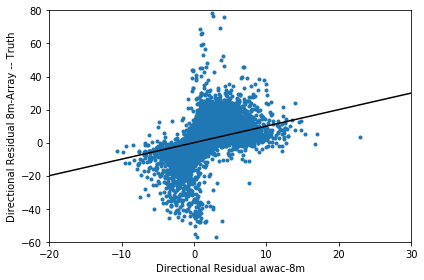

In [28]:
plt.subplot(111)
plt.plot(dirResiual_8m, dirResiual_acoustic, '.')
plt.plot([-45, 45], [-45, 45], 'k-')
plt.ylabel('Directional Residual 8m-Array -- Truth')
plt.xlabel('Directional Residual {}'.format(gauge))
plt.xlim([-20, 30])
plt.ylim([-60, 80])
plt.tight_layout()

_is this plot interesting?_

This shows that the directional residual with the acoustic gauge, while it follows similar trends, is much wider than that of the 8m array.  This is too be expected, but the amount of spread I consider surprising, at the  extremes 30 degrees difference!

In [110]:
# begin isolation of specific spectra
threshLower = 10  # look for values bigger than this 
threshUpper = 20
idxHighResidual = np.argwhere((np.abs(dirResiual_acoustic) > threshLower) & (obs_bulkStat_FP['Hm0']>.5) & (obs_bulkStat_FP['Tp']>7)).squeeze()
# obs_matched_HP['time'][idxHighResidual]
# idxOfInterest = idxHighResidual[6] # pick random index of interest from list 
# listInterest = [2, 4, 5, 6, 12, 18, 34]

# Begin looking at spectra
below are plots of wave spectra from the 8m array and the acoustic gauge (selected above). 
Specifically isolated are times when there is a Dm residual between 10 and 20 degrees for Half plane and Full plane 
(only when there is less than 0.05 m Hm0 differences between the two gauges -- in FP)
For Each Plot: 
the energy above the __Black line__ is ocean propagating (162), and the __white line__ is shore normal (72).  The Northern boundary for shore/ocean propagation was left out for clarity (its around 342).

Above each pair of plots is the date/time of the plot.  The 2nd line shows the Full plane statistics Hm0 and D_m for the acoustic gauge and the 8m array. The 3rd line shows the Half-planed bulk statistic and the last line shows the difference between full and half.  

Note: The color bars are the same between both plots, but the max has been reduced to 75% of the maximum value between the two spectra.  This was done to highlight the lower energy portions of the spectrum (the directional spread). 

In [109]:
obs_bulkStat_FP.keys()



dict_keys(['Hm0', 'Tp', 'Tm', 'Tave', 'Tm10', 'Dp', 'Dm', 'Dm2', 'Dm_p4', 'Dspec1', 'Dspec2', 'spreadF', 'spreadD', 'spreadDP_m1', 'spreadDP_m2', 'spreadD_f', 'skewnessD_f', 'meta'])

2009-01-07 19:00:00
awac-8m FP H_s: 0.59 [m] D_m 113.07 [deg] $\sigma$ 55.08 .... 8m-array FP H_s: 0.57 [m] D_m: 103.61 [deg] $\sigma$ 31.62
awac-8m HP H_s: 0.51 [m] D_m 100.54 [deg] $\sigma$ 36.04 .....8m-array HP H_s: 0.56 [m] D_m: 102.21 [deg] $\sigma$ 24.68

HP diff    H_s: 0.08 [m] D_m 12.52 [deg] $\sigma$ 19.04 ......        H_s: 0.01 [m] D_m: 1.40 [deg] $\sigma$ 6.94


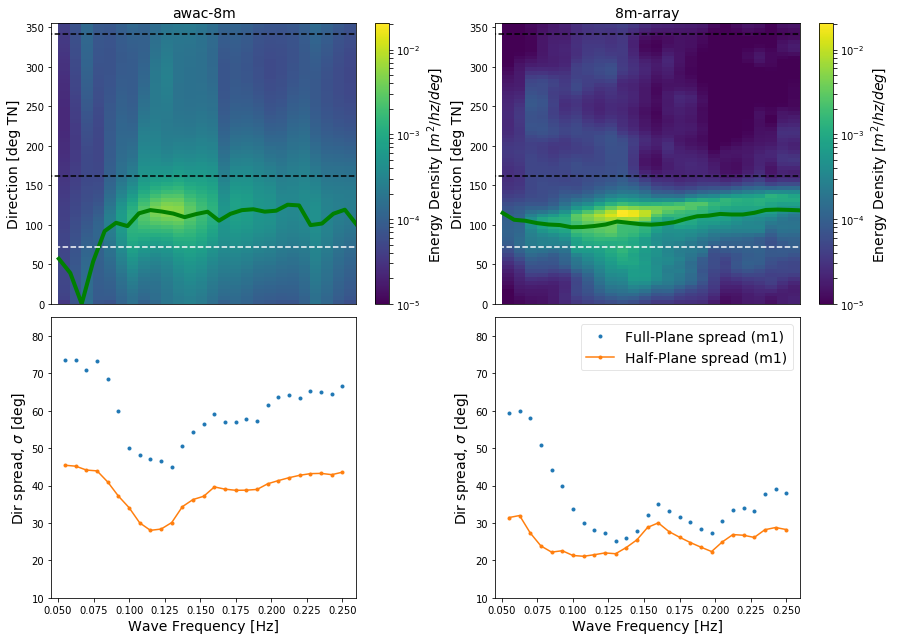

2009-01-07 21:00:00
awac-8m FP H_s: 0.53 [m] D_m 115.43 [deg] $\sigma$ 56.53 .... 8m-array FP H_s: 0.49 [m] D_m: 103.45 [deg] $\sigma$ 33.96
awac-8m HP H_s: 0.46 [m] D_m 99.49 [deg] $\sigma$ 38.36 .....8m-array HP H_s: 0.48 [m] D_m: 101.46 [deg] $\sigma$ 24.92

HP diff    H_s: 0.08 [m] D_m 15.94 [deg] $\sigma$ 18.18 ......        H_s: 0.02 [m] D_m: 2.00 [deg] $\sigma$ 9.04


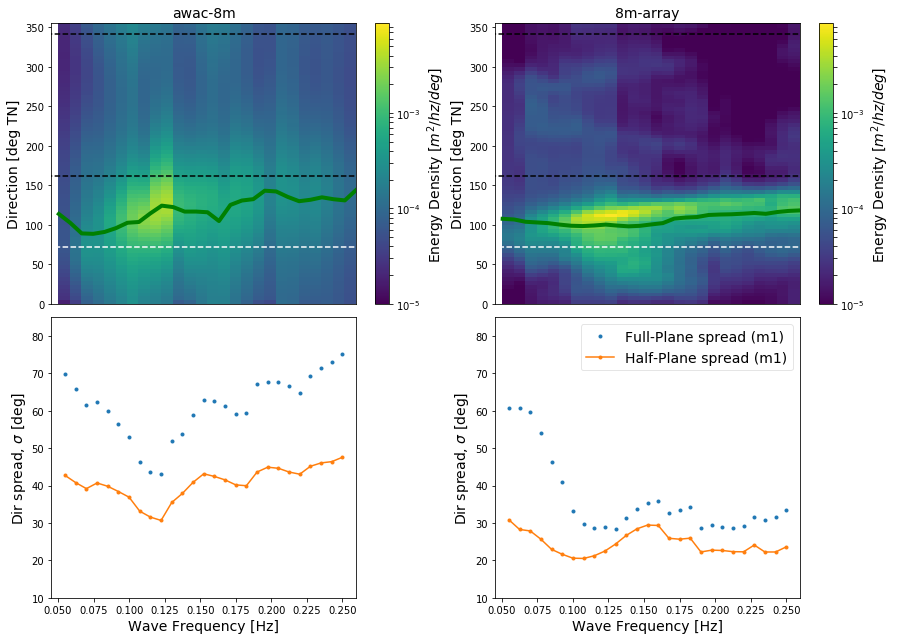

2009-01-11 01:00:00
awac-8m FP H_s: 0.51 [m] D_m 112.34 [deg] $\sigma$ 61.44 .... 8m-array FP H_s: 0.49 [m] D_m: 102.98 [deg] $\sigma$ 37.24
awac-8m HP H_s: 0.42 [m] D_m 94.30 [deg] $\sigma$ 39.94 .....8m-array HP H_s: 0.47 [m] D_m: 100.36 [deg] $\sigma$ 26.11

HP diff    H_s: 0.09 [m] D_m 18.04 [deg] $\sigma$ 21.51 ......        H_s: 0.02 [m] D_m: 2.62 [deg] $\sigma$ 11.13


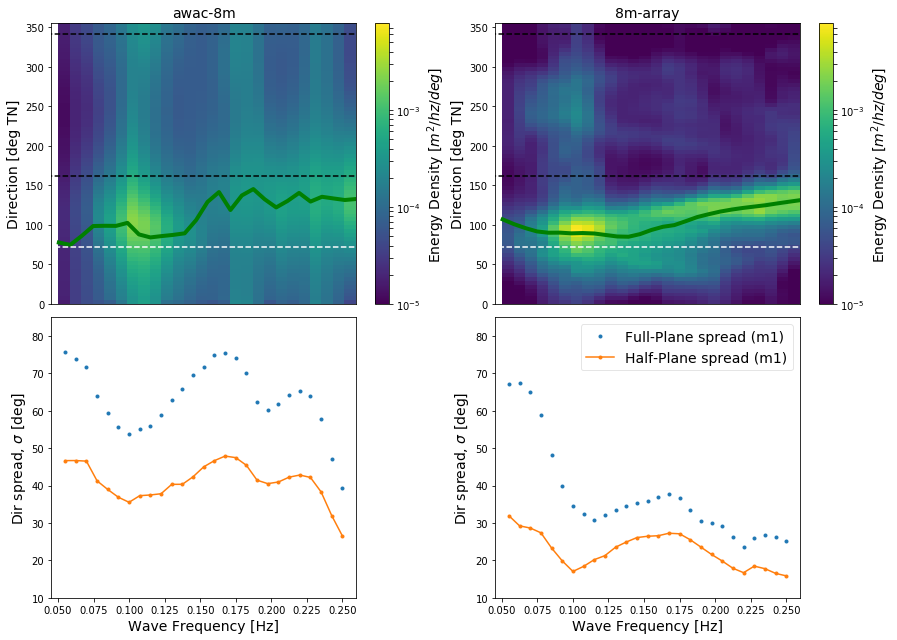

2009-01-11 08:00:00
awac-8m FP H_s: 0.60 [m] D_m 115.05 [deg] $\sigma$ 54.87 .... 8m-array FP H_s: 0.55 [m] D_m: 107.91 [deg] $\sigma$ 28.83
awac-8m HP H_s: 0.52 [m] D_m 100.08 [deg] $\sigma$ 37.51 .....8m-array HP H_s: 0.54 [m] D_m: 106.82 [deg] $\sigma$ 22.86

HP diff    H_s: 0.08 [m] D_m 14.97 [deg] $\sigma$ 17.36 ......        H_s: 0.01 [m] D_m: 1.10 [deg] $\sigma$ 5.97


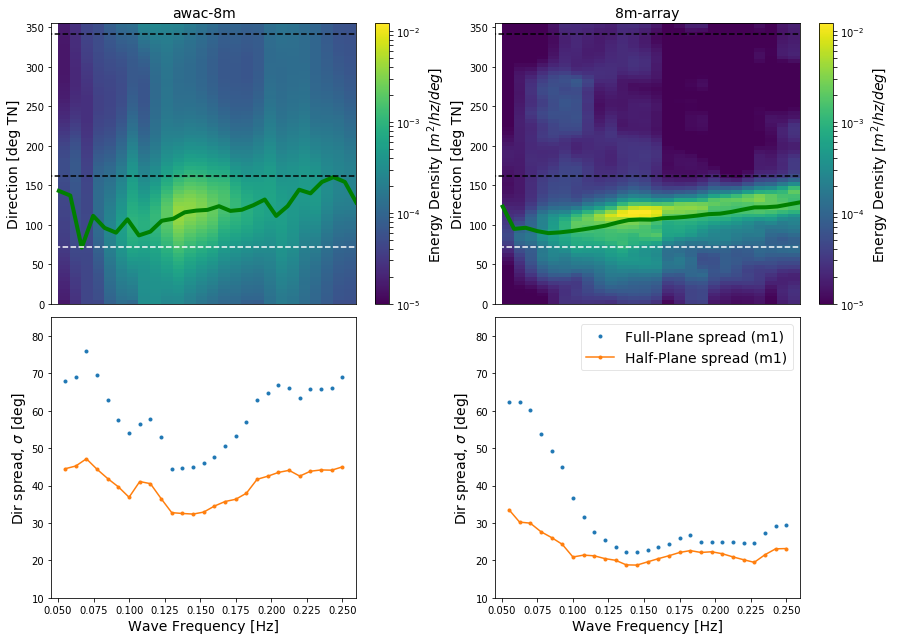

2009-01-11 11:00:00
awac-8m FP H_s: 0.66 [m] D_m 117.25 [deg] $\sigma$ 57.41 .... 8m-array FP H_s: 0.63 [m] D_m: 113.13 [deg] $\sigma$ 34.22
awac-8m HP H_s: 0.56 [m] D_m 101.30 [deg] $\sigma$ 37.28 .....8m-array HP H_s: 0.60 [m] D_m: 109.51 [deg] $\sigma$ 22.23

HP diff    H_s: 0.10 [m] D_m 15.95 [deg] $\sigma$ 20.14 ......        H_s: 0.03 [m] D_m: 3.62 [deg] $\sigma$ 11.99


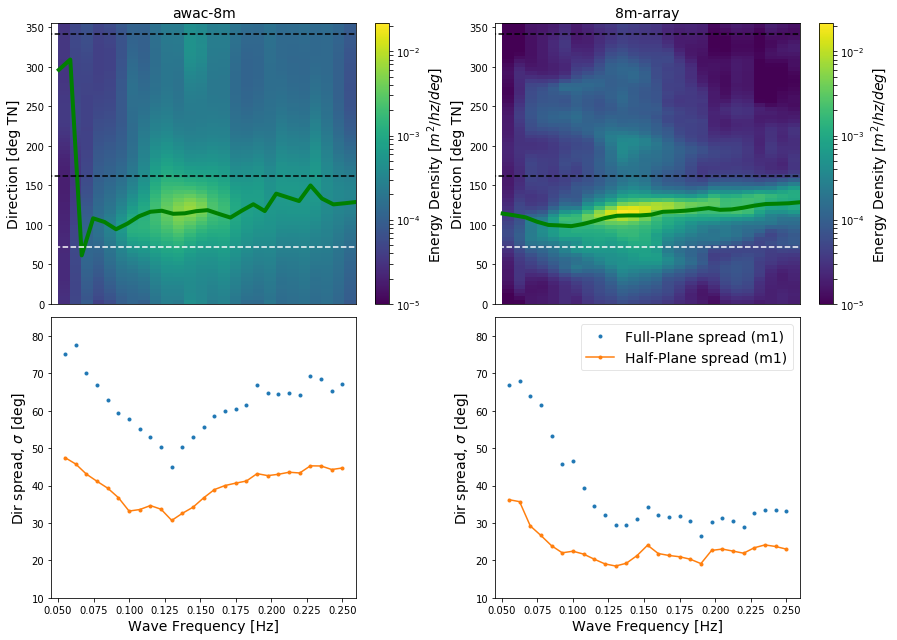

2009-01-11 13:00:00
awac-8m FP H_s: 0.62 [m] D_m 131.70 [deg] $\sigma$ 54.52 .... 8m-array FP H_s: 0.65 [m] D_m: 115.73 [deg] $\sigma$ 32.01
awac-8m HP H_s: 0.51 [m] D_m 109.31 [deg] $\sigma$ 36.12 .....8m-array HP H_s: 0.62 [m] D_m: 111.66 [deg] $\sigma$ 19.73

HP diff    H_s: 0.11 [m] D_m 22.39 [deg] $\sigma$ 18.40 ......        H_s: 0.03 [m] D_m: 4.07 [deg] $\sigma$ 12.28


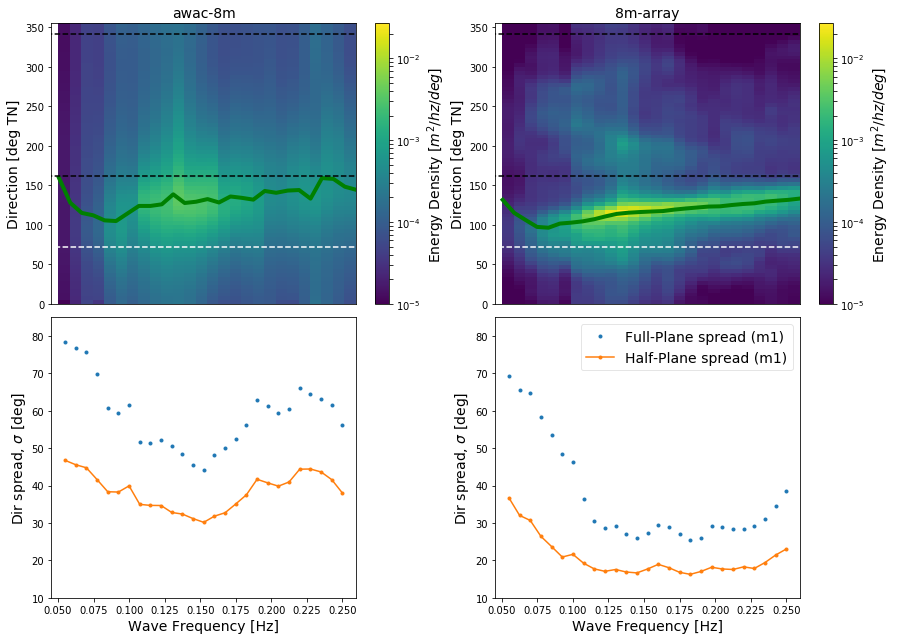

2009-01-11 15:00:00
awac-8m FP H_s: 0.66 [m] D_m 110.13 [deg] $\sigma$ 54.15 .... 8m-array FP H_s: 0.61 [m] D_m: 111.05 [deg] $\sigma$ 30.45
awac-8m HP H_s: 0.58 [m] D_m 98.33 [deg] $\sigma$ 36.08 .....8m-array HP H_s: 0.59 [m] D_m: 108.65 [deg] $\sigma$ 20.74

HP diff    H_s: 0.08 [m] D_m 11.80 [deg] $\sigma$ 18.08 ......        H_s: 0.02 [m] D_m: 2.39 [deg] $\sigma$ 9.71


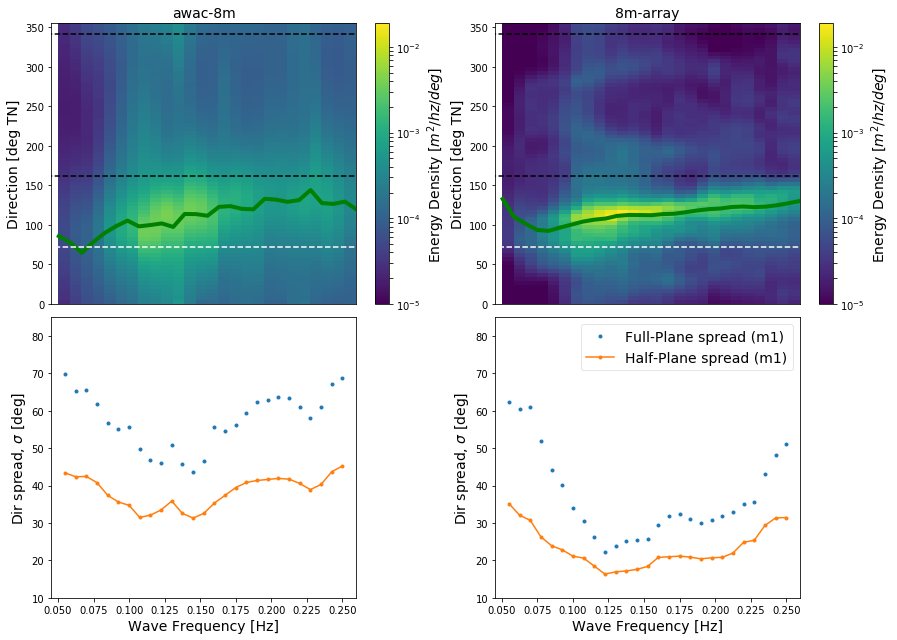

2009-01-19 16:00:00
awac-8m FP H_s: 0.53 [m] D_m 107.56 [deg] $\sigma$ 55.47 .... 8m-array FP H_s: 0.48 [m] D_m: 94.08 [deg] $\sigma$ 47.23
awac-8m HP H_s: 0.46 [m] D_m 95.62 [deg] $\sigma$ 35.75 .....8m-array HP H_s: 0.44 [m] D_m: 88.95 [deg] $\sigma$ 24.92

HP diff    H_s: 0.07 [m] D_m 11.94 [deg] $\sigma$ 19.72 ......        H_s: 0.04 [m] D_m: 5.13 [deg] $\sigma$ 22.31


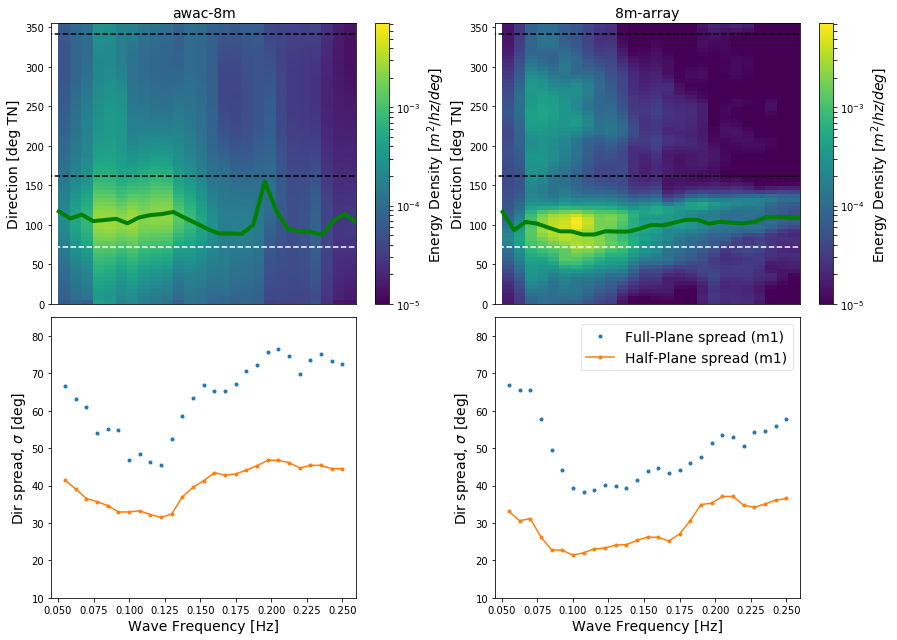

2009-01-20 04:00:00
awac-8m FP H_s: 0.53 [m] D_m 113.87 [deg] $\sigma$ 54.91 .... 8m-array FP H_s: 0.54 [m] D_m: 90.96 [deg] $\sigma$ 44.44
awac-8m HP H_s: 0.45 [m] D_m 97.91 [deg] $\sigma$ 35.60 .....8m-array HP H_s: 0.50 [m] D_m: 87.58 [deg] $\sigma$ 23.96

HP diff    H_s: 0.07 [m] D_m 15.96 [deg] $\sigma$ 19.31 ......        H_s: 0.04 [m] D_m: 3.37 [deg] $\sigma$ 20.48


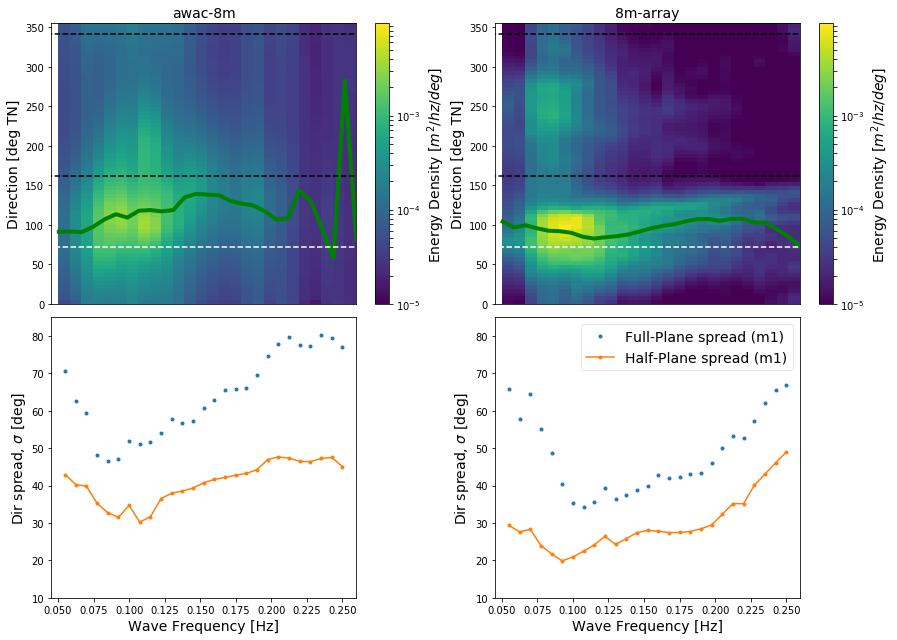

2009-01-28 21:00:00
awac-8m FP H_s: 0.63 [m] D_m 117.04 [deg] $\sigma$ 56.84 .... 8m-array FP H_s: 0.59 [m] D_m: 100.34 [deg] $\sigma$ 37.58
awac-8m HP H_s: 0.54 [m] D_m 99.01 [deg] $\sigma$ 36.83 .....8m-array HP H_s: 0.57 [m] D_m: 98.06 [deg] $\sigma$ 25.22

HP diff    H_s: 0.10 [m] D_m 18.02 [deg] $\sigma$ 20.01 ......        H_s: 0.02 [m] D_m: 2.27 [deg] $\sigma$ 12.36


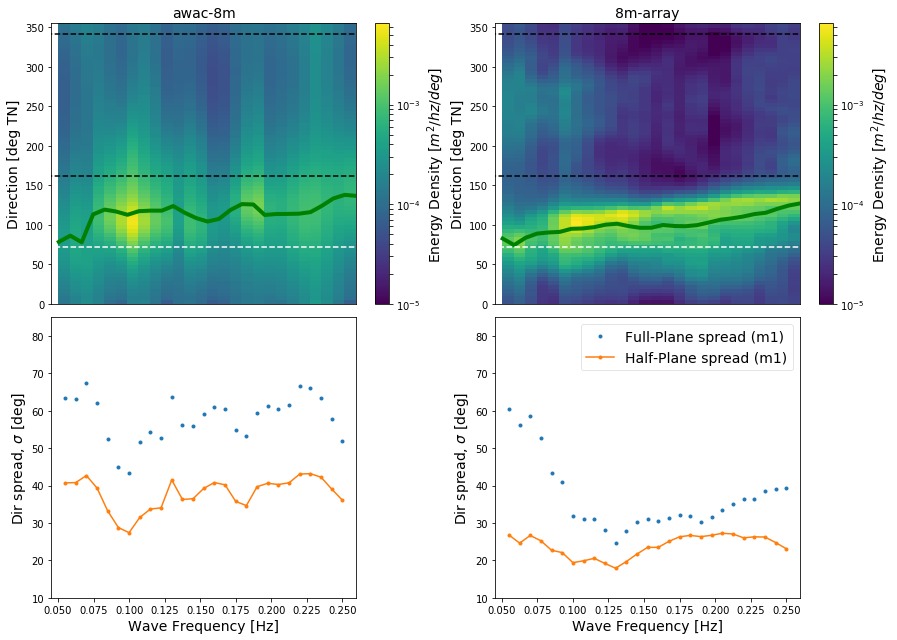

2009-01-28 22:00:00
awac-8m FP H_s: 0.61 [m] D_m 103.07 [deg] $\sigma$ 59.47 .... 8m-array FP H_s: 0.60 [m] D_m: 101.06 [deg] $\sigma$ 35.36
awac-8m HP H_s: 0.52 [m] D_m 90.81 [deg] $\sigma$ 37.70 .....8m-array HP H_s: 0.57 [m] D_m: 98.92 [deg] $\sigma$ 23.61

HP diff    H_s: 0.09 [m] D_m 12.26 [deg] $\sigma$ 21.77 ......        H_s: 0.02 [m] D_m: 2.14 [deg] $\sigma$ 11.74


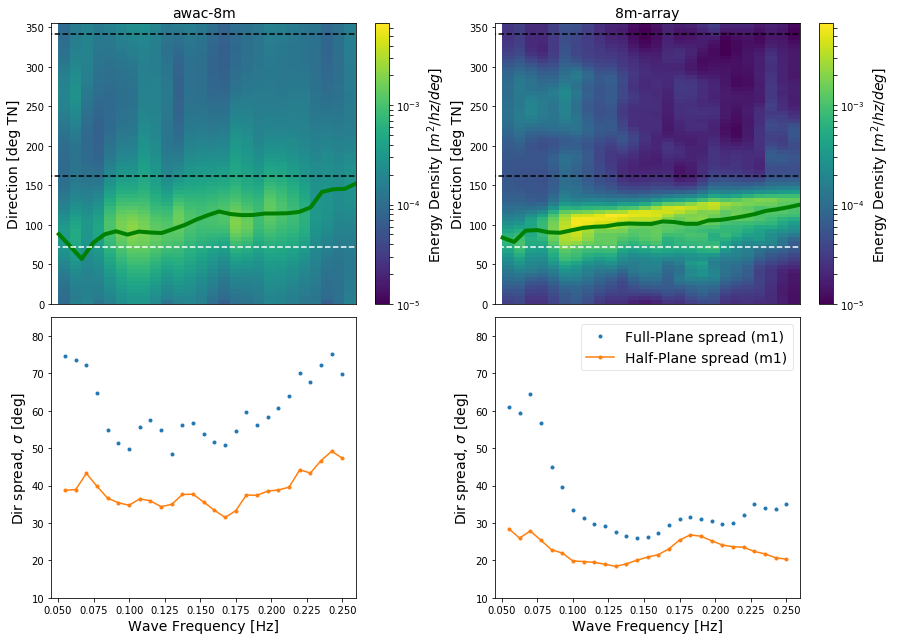

2009-01-28 23:00:00
awac-8m FP H_s: 0.60 [m] D_m 100.78 [deg] $\sigma$ 58.84 .... 8m-array FP H_s: 0.60 [m] D_m: 101.81 [deg] $\sigma$ 37.14
awac-8m HP H_s: 0.53 [m] D_m 90.35 [deg] $\sigma$ 40.56 .....8m-array HP H_s: 0.58 [m] D_m: 98.99 [deg] $\sigma$ 23.27

HP diff    H_s: 0.08 [m] D_m 10.43 [deg] $\sigma$ 18.27 ......        H_s: 0.03 [m] D_m: 2.82 [deg] $\sigma$ 13.87


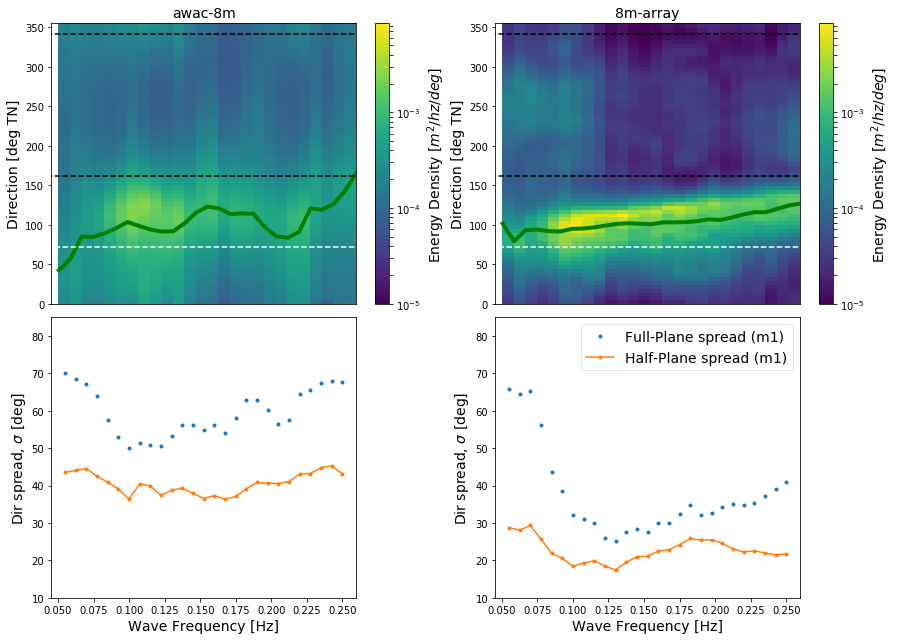

2009-01-29 01:00:00
awac-8m FP H_s: 0.57 [m] D_m 102.15 [deg] $\sigma$ 58.57 .... 8m-array FP H_s: 0.56 [m] D_m: 101.27 [deg] $\sigma$ 39.02
awac-8m HP H_s: 0.49 [m] D_m 91.34 [deg] $\sigma$ 38.35 .....8m-array HP H_s: 0.54 [m] D_m: 98.15 [deg] $\sigma$ 23.75

HP diff    H_s: 0.08 [m] D_m 10.80 [deg] $\sigma$ 20.22 ......        H_s: 0.03 [m] D_m: 3.12 [deg] $\sigma$ 15.28


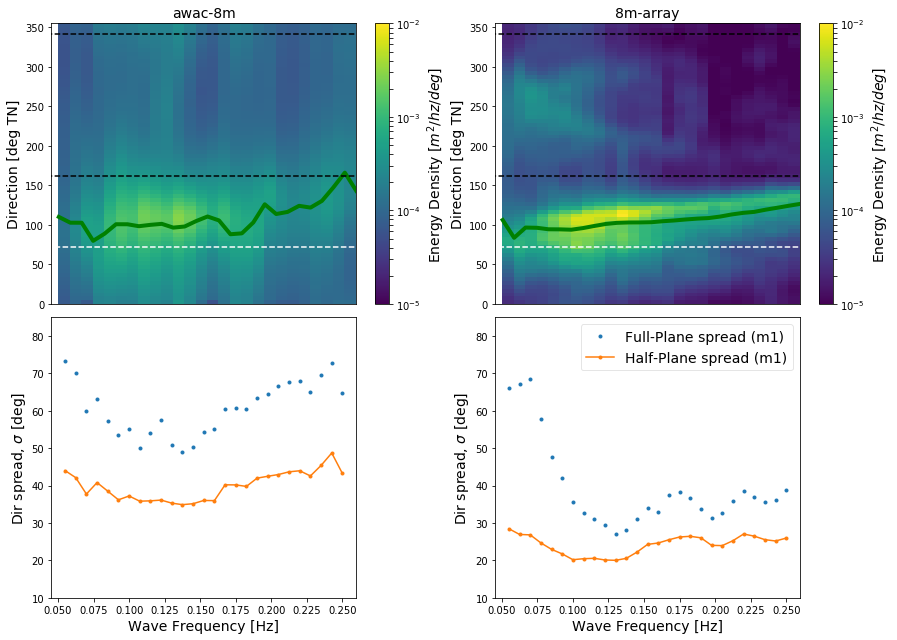

2009-01-29 03:00:00
awac-8m FP H_s: 0.53 [m] D_m 112.70 [deg] $\sigma$ 54.24 .... 8m-array FP H_s: 0.51 [m] D_m: 97.32 [deg] $\sigma$ 41.99
awac-8m HP H_s: 0.46 [m] D_m 99.48 [deg] $\sigma$ 36.00 .....8m-array HP H_s: 0.48 [m] D_m: 93.75 [deg] $\sigma$ 25.52

HP diff    H_s: 0.07 [m] D_m 13.23 [deg] $\sigma$ 18.24 ......        H_s: 0.03 [m] D_m: 3.57 [deg] $\sigma$ 16.47


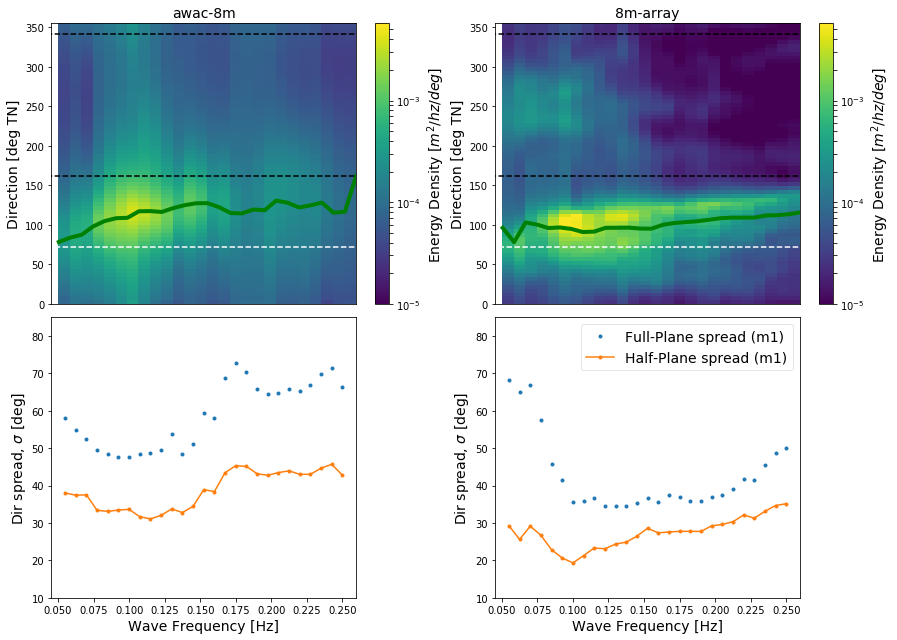

2009-01-29 04:00:00
awac-8m FP H_s: 0.54 [m] D_m 108.82 [deg] $\sigma$ 57.70 .... 8m-array FP H_s: 0.51 [m] D_m: 96.53 [deg] $\sigma$ 41.37
awac-8m HP H_s: 0.46 [m] D_m 94.43 [deg] $\sigma$ 37.94 .....8m-array HP H_s: 0.48 [m] D_m: 93.44 [deg] $\sigma$ 25.53

HP diff    H_s: 0.08 [m] D_m 14.39 [deg] $\sigma$ 19.76 ......        H_s: 0.03 [m] D_m: 3.09 [deg] $\sigma$ 15.84


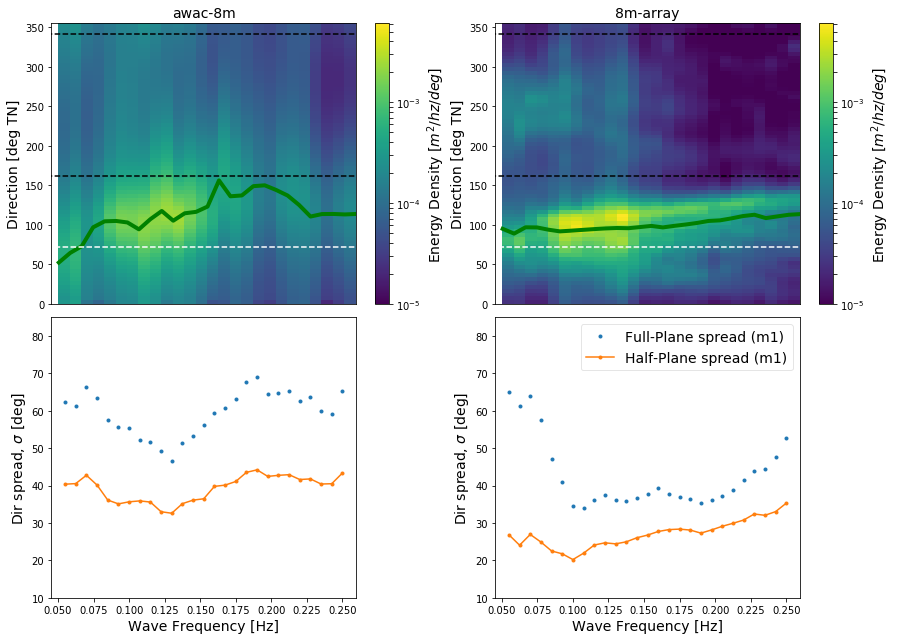

2009-01-29 06:00:00
awac-8m FP H_s: 0.54 [m] D_m 108.45 [deg] $\sigma$ 56.03 .... 8m-array FP H_s: 0.51 [m] D_m: 91.19 [deg] $\sigma$ 41.63
awac-8m HP H_s: 0.47 [m] D_m 95.82 [deg] $\sigma$ 36.30 .....8m-array HP H_s: 0.48 [m] D_m: 88.69 [deg] $\sigma$ 26.81

HP diff    H_s: 0.07 [m] D_m 12.63 [deg] $\sigma$ 19.73 ......        H_s: 0.03 [m] D_m: 2.49 [deg] $\sigma$ 14.82


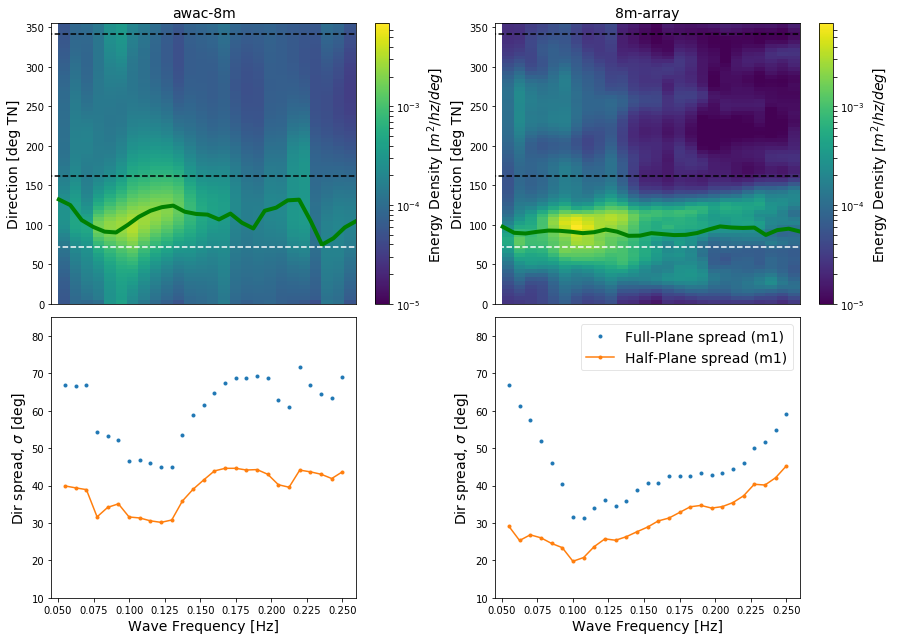

2009-02-11 00:00:00
awac-8m FP H_s: 0.56 [m] D_m 101.16 [deg] $\sigma$ 58.96 .... 8m-array FP H_s: 0.51 [m] D_m: 89.84 [deg] $\sigma$ 41.04
awac-8m HP H_s: 0.48 [m] D_m 88.82 [deg] $\sigma$ 37.38 .....8m-array HP H_s: 0.49 [m] D_m: 87.79 [deg] $\sigma$ 26.27

HP diff    H_s: 0.08 [m] D_m 12.34 [deg] $\sigma$ 21.58 ......        H_s: 0.02 [m] D_m: 2.05 [deg] $\sigma$ 14.78


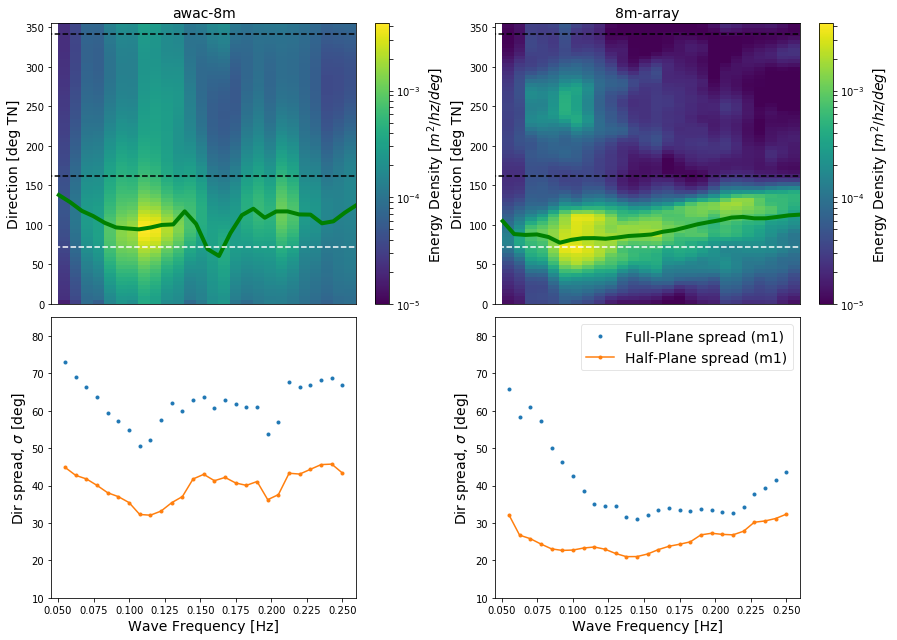

2009-02-11 22:00:00
awac-8m FP H_s: 0.52 [m] D_m 115.89 [deg] $\sigma$ 57.30 .... 8m-array FP H_s: 0.50 [m] D_m: 101.37 [deg] $\sigma$ 36.59
awac-8m HP H_s: 0.44 [m] D_m 98.62 [deg] $\sigma$ 37.23 .....8m-array HP H_s: 0.48 [m] D_m: 99.03 [deg] $\sigma$ 24.93

HP diff    H_s: 0.08 [m] D_m 17.27 [deg] $\sigma$ 20.07 ......        H_s: 0.02 [m] D_m: 2.34 [deg] $\sigma$ 11.66


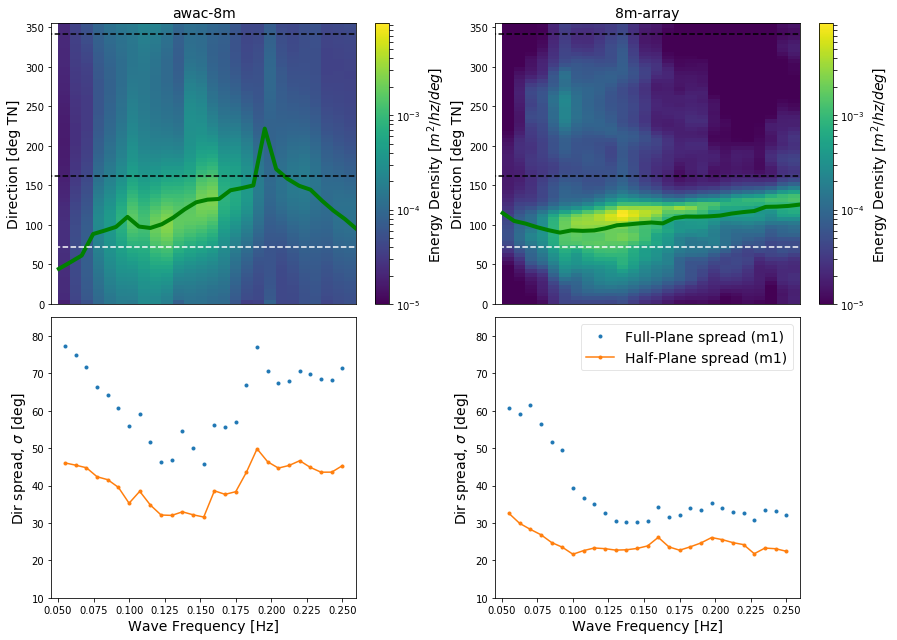

2009-02-11 23:00:00
awac-8m FP H_s: 0.52 [m] D_m 109.92 [deg] $\sigma$ 57.25 .... 8m-array FP H_s: 0.52 [m] D_m: 105.45 [deg] $\sigma$ 36.58
awac-8m HP H_s: 0.45 [m] D_m 95.41 [deg] $\sigma$ 36.80 .....8m-array HP H_s: 0.50 [m] D_m: 102.65 [deg] $\sigma$ 24.70

HP diff    H_s: 0.07 [m] D_m 14.51 [deg] $\sigma$ 20.44 ......        H_s: 0.02 [m] D_m: 2.80 [deg] $\sigma$ 11.88


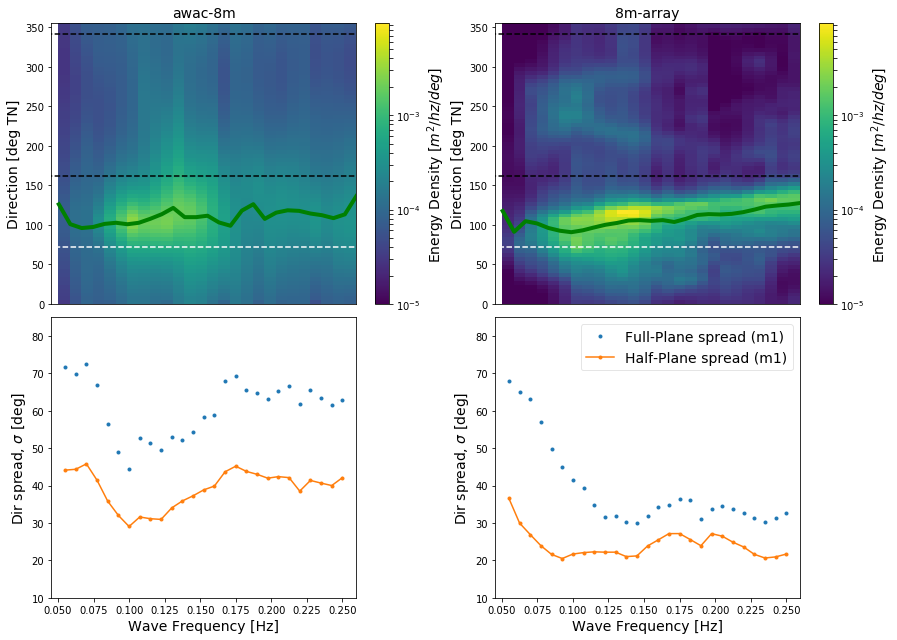

2009-02-12 00:00:00
awac-8m FP H_s: 0.57 [m] D_m 110.53 [deg] $\sigma$ 59.49 .... 8m-array FP H_s: 0.52 [m] D_m: 107.23 [deg] $\sigma$ 37.51
awac-8m HP H_s: 0.48 [m] D_m 95.46 [deg] $\sigma$ 38.68 .....8m-array HP H_s: 0.50 [m] D_m: 104.04 [deg] $\sigma$ 24.74

HP diff    H_s: 0.09 [m] D_m 15.06 [deg] $\sigma$ 20.81 ......        H_s: 0.02 [m] D_m: 3.19 [deg] $\sigma$ 12.77


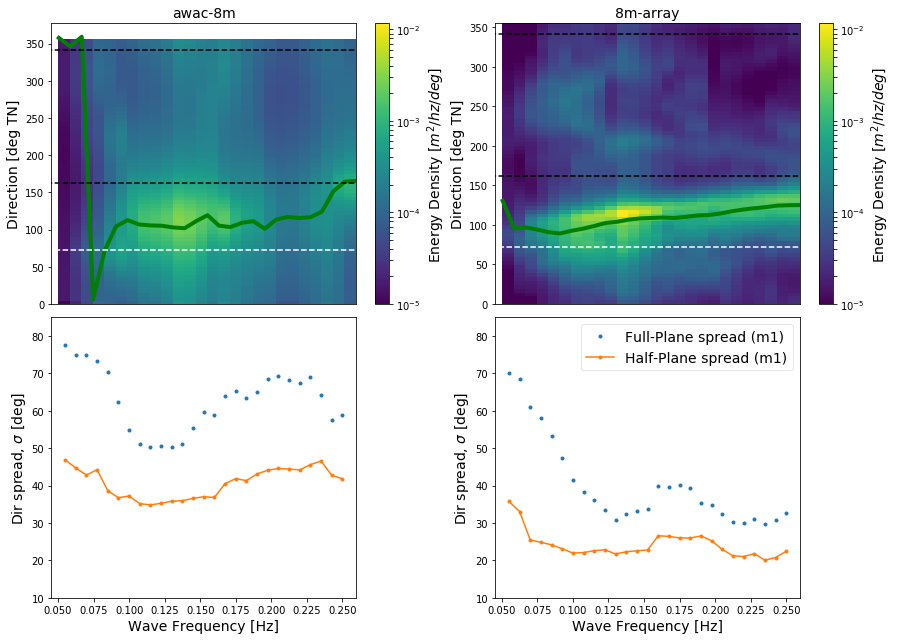

2009-02-12 03:00:00
awac-8m FP H_s: 0.57 [m] D_m 117.16 [deg] $\sigma$ 58.91 .... 8m-array FP H_s: 0.53 [m] D_m: 111.29 [deg] $\sigma$ 34.21
awac-8m HP H_s: 0.48 [m] D_m 97.76 [deg] $\sigma$ 38.96 .....8m-array HP H_s: 0.51 [m] D_m: 108.03 [deg] $\sigma$ 22.35

HP diff    H_s: 0.09 [m] D_m 19.41 [deg] $\sigma$ 19.94 ......        H_s: 0.02 [m] D_m: 3.26 [deg] $\sigma$ 11.86


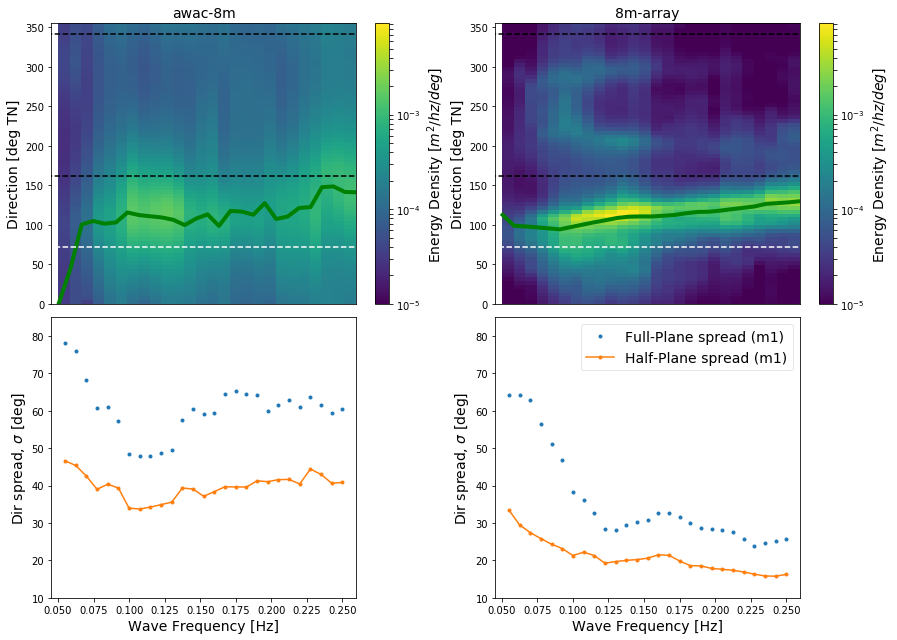

2009-02-12 06:00:00
awac-8m FP H_s: 0.52 [m] D_m 118.25 [deg] $\sigma$ 61.07 .... 8m-array FP H_s: 0.47 [m] D_m: 113.51 [deg] $\sigma$ 33.34
awac-8m HP H_s: 0.43 [m] D_m 96.35 [deg] $\sigma$ 39.24 .....8m-array HP H_s: 0.45 [m] D_m: 110.76 [deg] $\sigma$ 23.16

HP diff    H_s: 0.09 [m] D_m 21.90 [deg] $\sigma$ 21.83 ......        H_s: 0.02 [m] D_m: 2.76 [deg] $\sigma$ 10.18


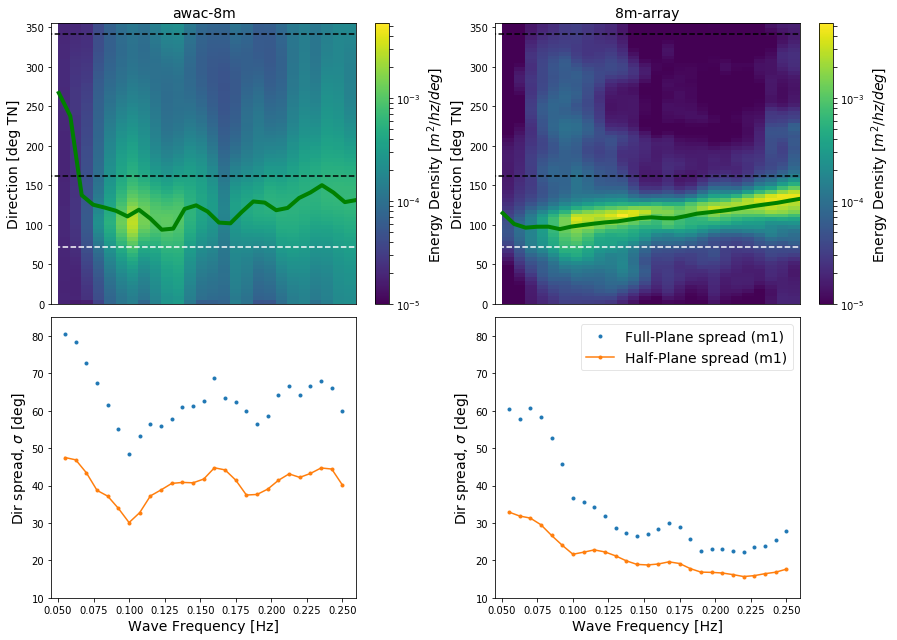

2009-02-12 11:00:00
awac-8m FP H_s: 0.57 [m] D_m 113.77 [deg] $\sigma$ 55.38 .... 8m-array FP H_s: 0.53 [m] D_m: 103.77 [deg] $\sigma$ 36.81
awac-8m HP H_s: 0.49 [m] D_m 100.33 [deg] $\sigma$ 36.41 .....8m-array HP H_s: 0.50 [m] D_m: 100.53 [deg] $\sigma$ 23.02

HP diff    H_s: 0.08 [m] D_m 13.45 [deg] $\sigma$ 18.97 ......        H_s: 0.03 [m] D_m: 3.24 [deg] $\sigma$ 13.79


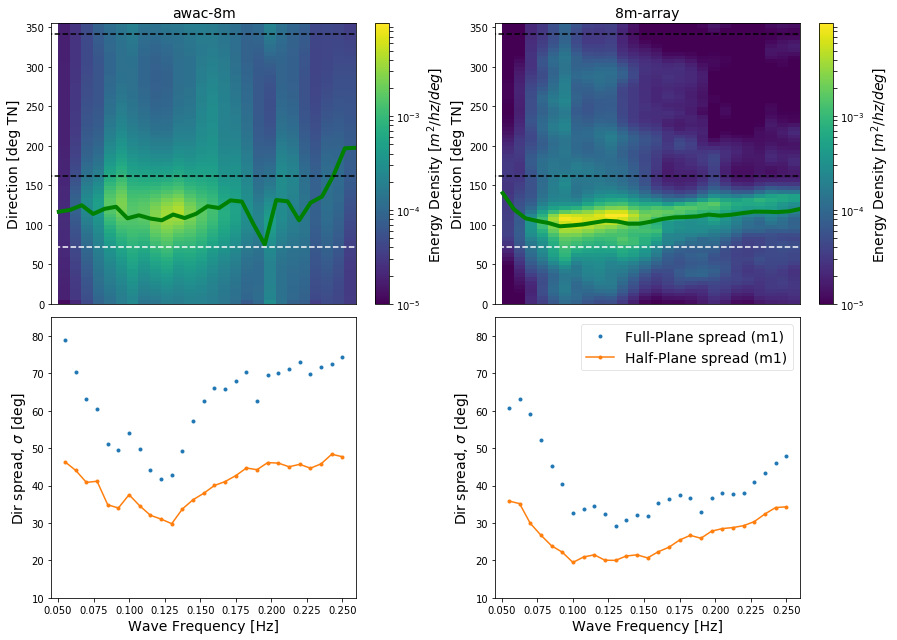

2009-02-27 23:00:00
awac-8m FP H_s: 0.50 [m] D_m 100.65 [deg] $\sigma$ 60.22 .... 8m-array FP H_s: 0.48 [m] D_m: 99.33 [deg] $\sigma$ 38.82
awac-8m HP H_s: 0.43 [m] D_m 87.90 [deg] $\sigma$ 39.62 .....8m-array HP H_s: 0.46 [m] D_m: 96.26 [deg] $\sigma$ 23.98

HP diff    H_s: 0.07 [m] D_m 12.76 [deg] $\sigma$ 20.60 ......        H_s: 0.02 [m] D_m: 3.07 [deg] $\sigma$ 14.85


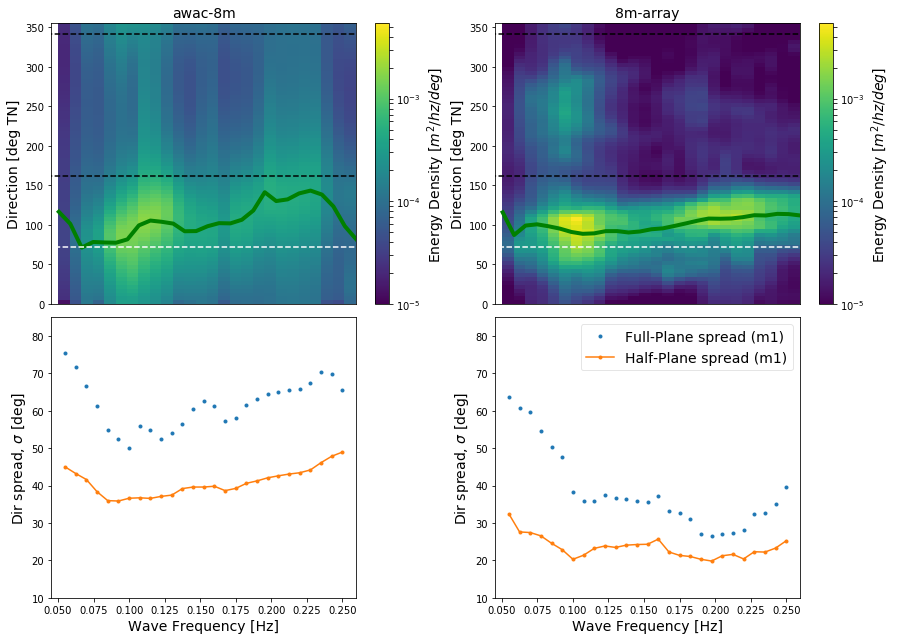

2009-02-28 00:00:00
awac-8m FP H_s: 0.52 [m] D_m 98.13 [deg] $\sigma$ 60.32 .... 8m-array FP H_s: 0.52 [m] D_m: 100.75 [deg] $\sigma$ 38.09
awac-8m HP H_s: 0.45 [m] D_m 87.77 [deg] $\sigma$ 39.65 .....8m-array HP H_s: 0.50 [m] D_m: 97.73 [deg] $\sigma$ 23.21

HP diff    H_s: 0.07 [m] D_m 10.36 [deg] $\sigma$ 20.67 ......        H_s: 0.02 [m] D_m: 3.02 [deg] $\sigma$ 14.88


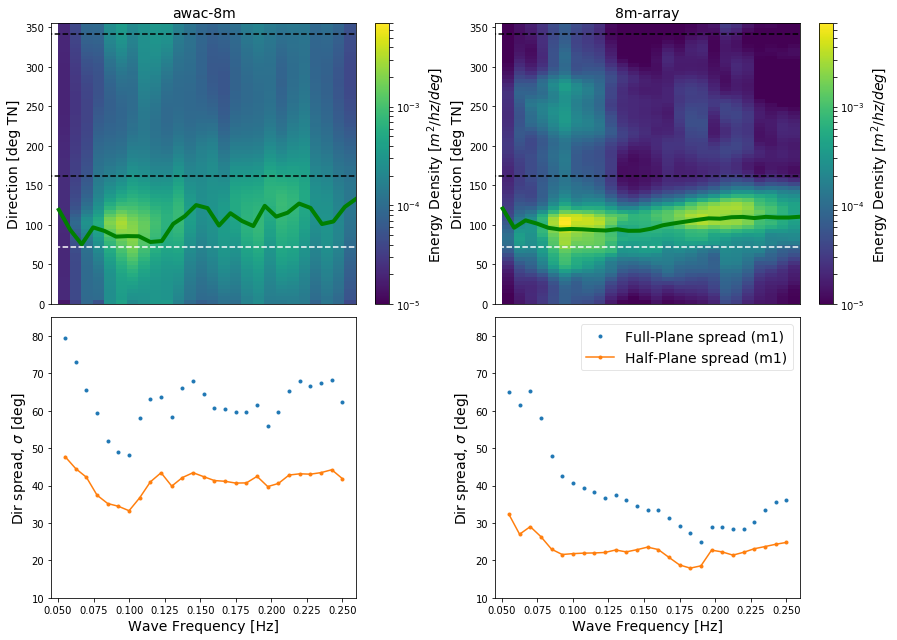

2009-02-28 03:00:00
awac-8m FP H_s: 0.55 [m] D_m 118.51 [deg] $\sigma$ 58.26 .... 8m-array FP H_s: 0.54 [m] D_m: 102.62 [deg] $\sigma$ 35.49
awac-8m HP H_s: 0.46 [m] D_m 99.58 [deg] $\sigma$ 37.85 .....8m-array HP H_s: 0.52 [m] D_m: 99.76 [deg] $\sigma$ 22.54

HP diff    H_s: 0.09 [m] D_m 18.93 [deg] $\sigma$ 20.40 ......        H_s: 0.02 [m] D_m: 2.86 [deg] $\sigma$ 12.95


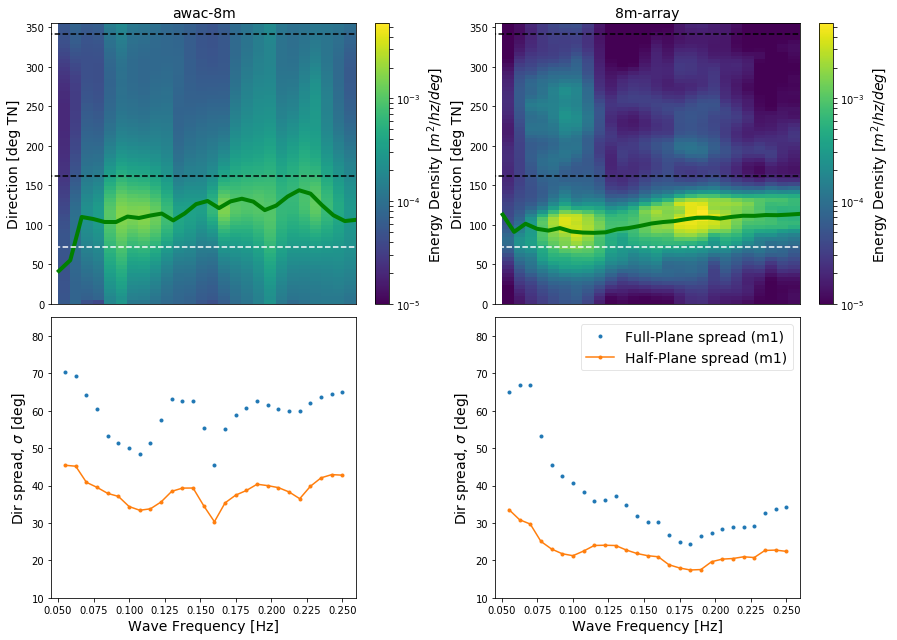

2009-02-28 07:00:00
awac-8m FP H_s: 0.53 [m] D_m 102.42 [deg] $\sigma$ 59.02 .... 8m-array FP H_s: 0.50 [m] D_m: 98.87 [deg] $\sigma$ 34.01
awac-8m HP H_s: 0.46 [m] D_m 90.03 [deg] $\sigma$ 39.12 .....8m-array HP H_s: 0.49 [m] D_m: 96.97 [deg] $\sigma$ 22.75

HP diff    H_s: 0.07 [m] D_m 12.39 [deg] $\sigma$ 19.90 ......        H_s: 0.02 [m] D_m: 1.90 [deg] $\sigma$ 11.26


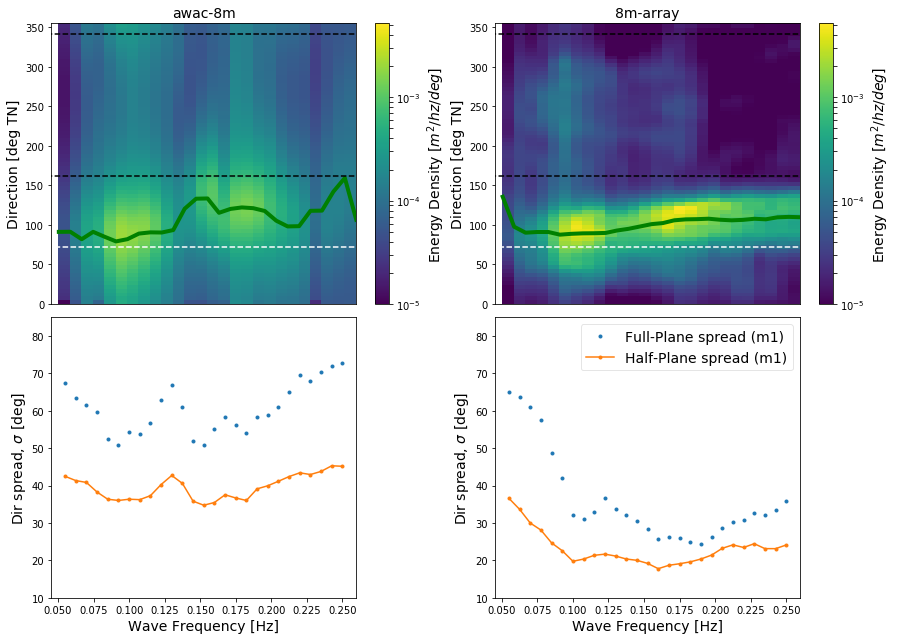

2009-03-06 05:00:00
awac-8m FP H_s: 0.52 [m] D_m 103.16 [deg] $\sigma$ 57.29 .... 8m-array FP H_s: 0.49 [m] D_m: 86.39 [deg] $\sigma$ 51.73
awac-8m HP H_s: 0.46 [m] D_m 91.13 [deg] $\sigma$ 36.46 .....8m-array HP H_s: 0.44 [m] D_m: 81.90 [deg] $\sigma$ 25.22

HP diff    H_s: 0.07 [m] D_m 12.03 [deg] $\sigma$ 20.83 ......        H_s: 0.05 [m] D_m: 4.49 [deg] $\sigma$ 26.51


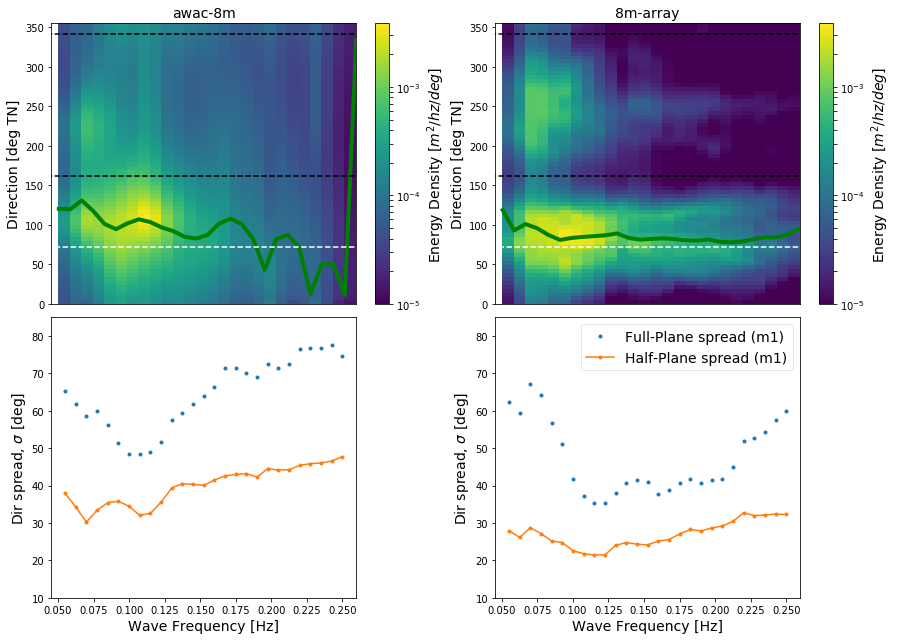

2009-03-07 12:00:00
awac-8m FP H_s: 0.50 [m] D_m 96.32 [deg] $\sigma$ 54.39 .... 8m-array FP H_s: 0.47 [m] D_m: 92.92 [deg] $\sigma$ 50.99
awac-8m HP H_s: 0.44 [m] D_m 85.69 [deg] $\sigma$ 32.76 .....8m-array HP H_s: 0.42 [m] D_m: 87.82 [deg] $\sigma$ 27.42

HP diff    H_s: 0.06 [m] D_m 10.63 [deg] $\sigma$ 21.63 ......        H_s: 0.04 [m] D_m: 5.10 [deg] $\sigma$ 23.57


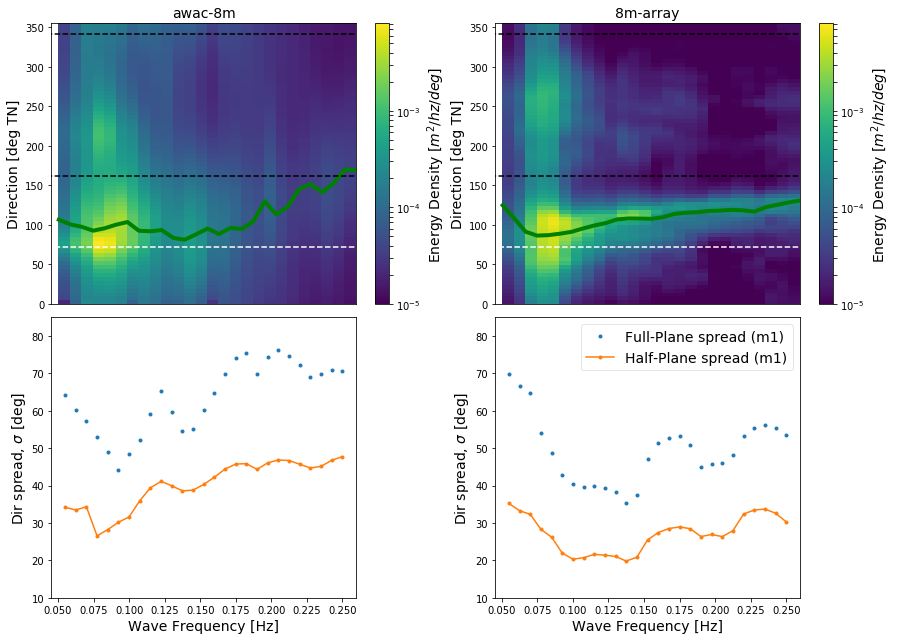

2009-03-29 02:00:00
awac-8m FP H_s: 0.73 [m] D_m 109.99 [deg] $\sigma$ 54.83 .... 8m-array FP H_s: 0.71 [m] D_m: 88.04 [deg] $\sigma$ 44.79
awac-8m HP H_s: 0.63 [m] D_m 95.48 [deg] $\sigma$ 36.73 .....8m-array HP H_s: 0.67 [m] D_m: 85.44 [deg] $\sigma$ 29.21

HP diff    H_s: 0.10 [m] D_m 14.51 [deg] $\sigma$ 18.10 ......        H_s: 0.04 [m] D_m: 2.60 [deg] $\sigma$ 15.58


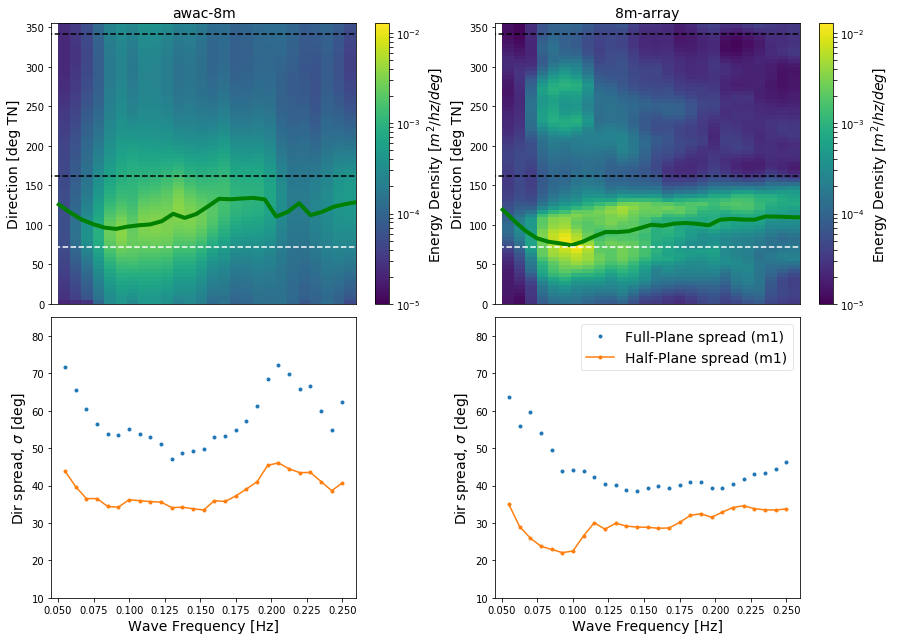

2009-03-29 08:00:00
awac-8m FP H_s: 0.67 [m] D_m 109.15 [deg] $\sigma$ 53.91 .... 8m-array FP H_s: 0.67 [m] D_m: 96.14 [deg] $\sigma$ 38.83
awac-8m HP H_s: 0.59 [m] D_m 95.75 [deg] $\sigma$ 36.33 .....8m-array HP H_s: 0.64 [m] D_m: 94.03 [deg] $\sigma$ 28.82

HP diff    H_s: 0.08 [m] D_m 13.41 [deg] $\sigma$ 17.58 ......        H_s: 0.03 [m] D_m: 2.11 [deg] $\sigma$ 10.01


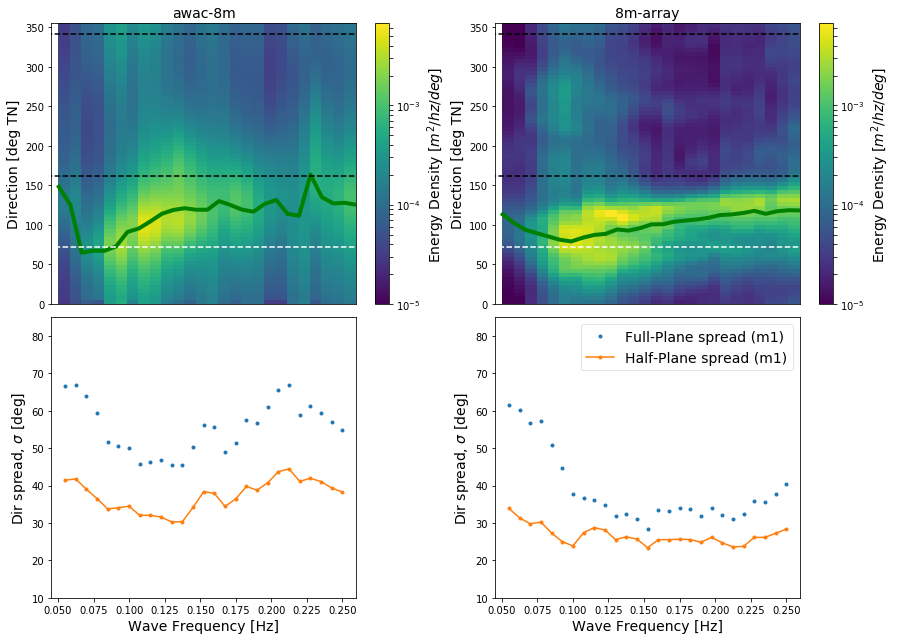

2009-03-29 09:00:00
awac-8m FP H_s: 0.70 [m] D_m 107.94 [deg] $\sigma$ 55.34 .... 8m-array FP H_s: 0.68 [m] D_m: 95.74 [deg] $\sigma$ 37.55
awac-8m HP H_s: 0.61 [m] D_m 95.21 [deg] $\sigma$ 37.93 .....8m-array HP H_s: 0.65 [m] D_m: 93.84 [deg] $\sigma$ 27.93

HP diff    H_s: 0.09 [m] D_m 12.73 [deg] $\sigma$ 17.41 ......        H_s: 0.02 [m] D_m: 1.90 [deg] $\sigma$ 9.62


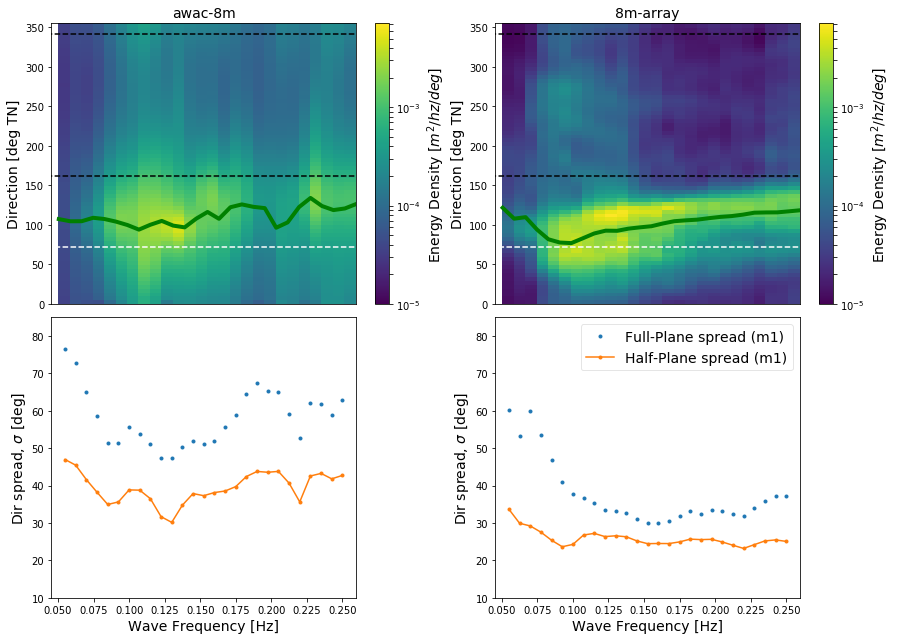

2009-03-29 10:00:00
awac-8m FP H_s: 0.73 [m] D_m 104.21 [deg] $\sigma$ 54.48 .... 8m-array FP H_s: 0.69 [m] D_m: 97.54 [deg] $\sigma$ 37.75
awac-8m HP H_s: 0.64 [m] D_m 93.21 [deg] $\sigma$ 35.82 .....8m-array HP H_s: 0.66 [m] D_m: 95.31 [deg] $\sigma$ 27.07

HP diff    H_s: 0.09 [m] D_m 10.99 [deg] $\sigma$ 18.67 ......        H_s: 0.03 [m] D_m: 2.23 [deg] $\sigma$ 10.68


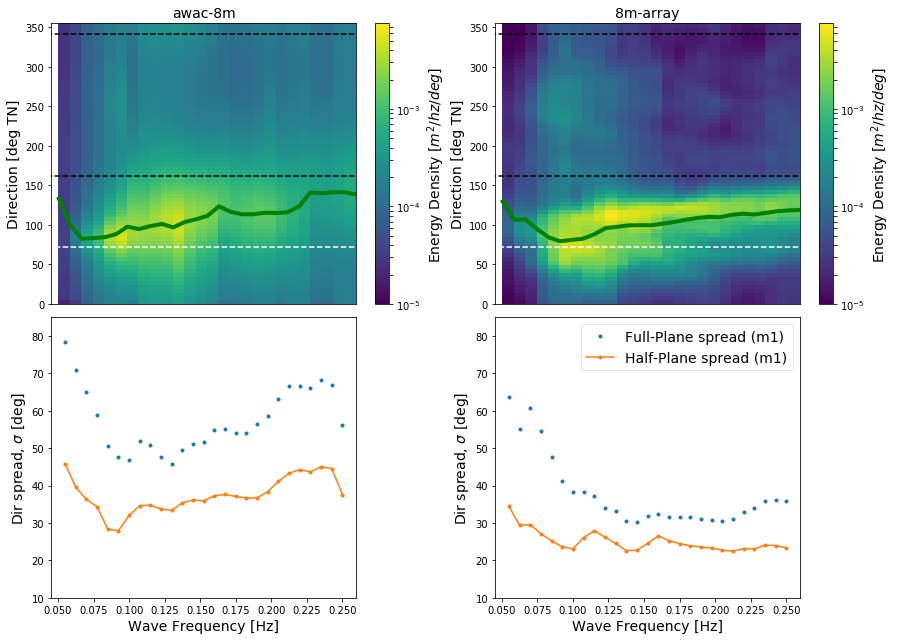

2009-03-29 17:00:00
awac-8m FP H_s: 0.65 [m] D_m 104.92 [deg] $\sigma$ 56.78 .... 8m-array FP H_s: 0.60 [m] D_m: 98.76 [deg] $\sigma$ 38.73
awac-8m HP H_s: 0.56 [m] D_m 91.59 [deg] $\sigma$ 36.60 .....8m-array HP H_s: 0.57 [m] D_m: 96.21 [deg] $\sigma$ 27.02

HP diff    H_s: 0.09 [m] D_m 13.33 [deg] $\sigma$ 20.18 ......        H_s: 0.03 [m] D_m: 2.55 [deg] $\sigma$ 11.70


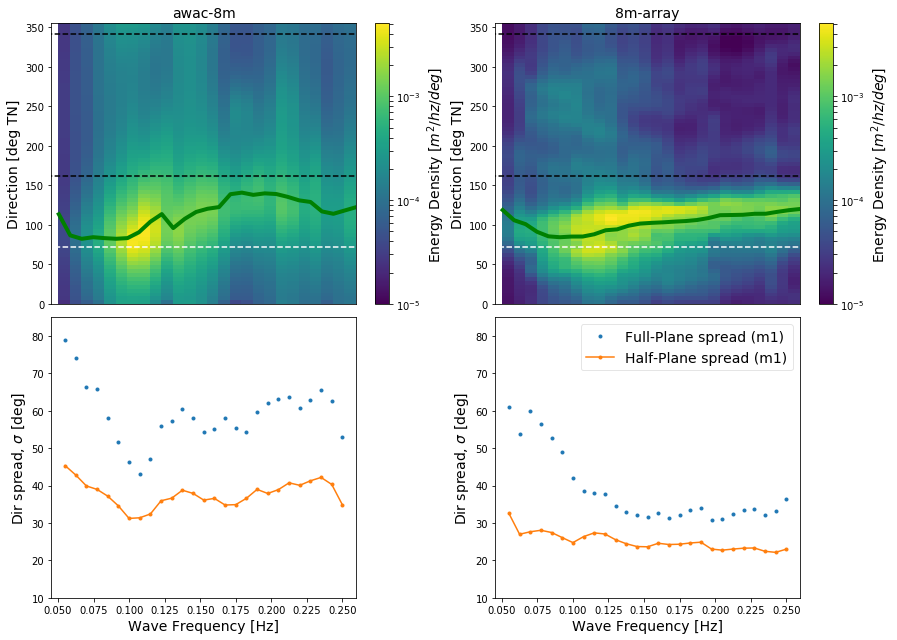

2009-03-30 01:00:00
awac-8m FP H_s: 0.60 [m] D_m 113.32 [deg] $\sigma$ 57.27 .... 8m-array FP H_s: 0.59 [m] D_m: 103.20 [deg] $\sigma$ 44.99
awac-8m HP H_s: 0.51 [m] D_m 96.61 [deg] $\sigma$ 38.30 .....8m-array HP H_s: 0.54 [m] D_m: 97.36 [deg] $\sigma$ 26.43

HP diff    H_s: 0.09 [m] D_m 16.71 [deg] $\sigma$ 18.96 ......        H_s: 0.04 [m] D_m: 5.84 [deg] $\sigma$ 18.56


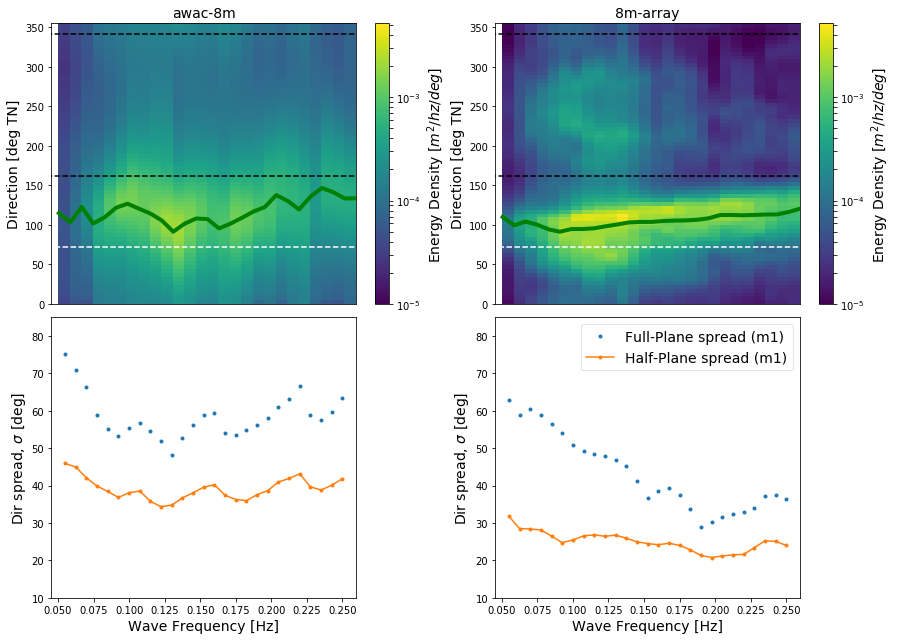

2009-03-30 02:00:00
awac-8m FP H_s: 0.54 [m] D_m 108.30 [deg] $\sigma$ 61.20 .... 8m-array FP H_s: 0.53 [m] D_m: 103.21 [deg] $\sigma$ 46.40
awac-8m HP H_s: 0.46 [m] D_m 92.36 [deg] $\sigma$ 41.05 .....8m-array HP H_s: 0.49 [m] D_m: 96.91 [deg] $\sigma$ 27.54

HP diff    H_s: 0.08 [m] D_m 15.94 [deg] $\sigma$ 20.15 ......        H_s: 0.04 [m] D_m: 6.30 [deg] $\sigma$ 18.85


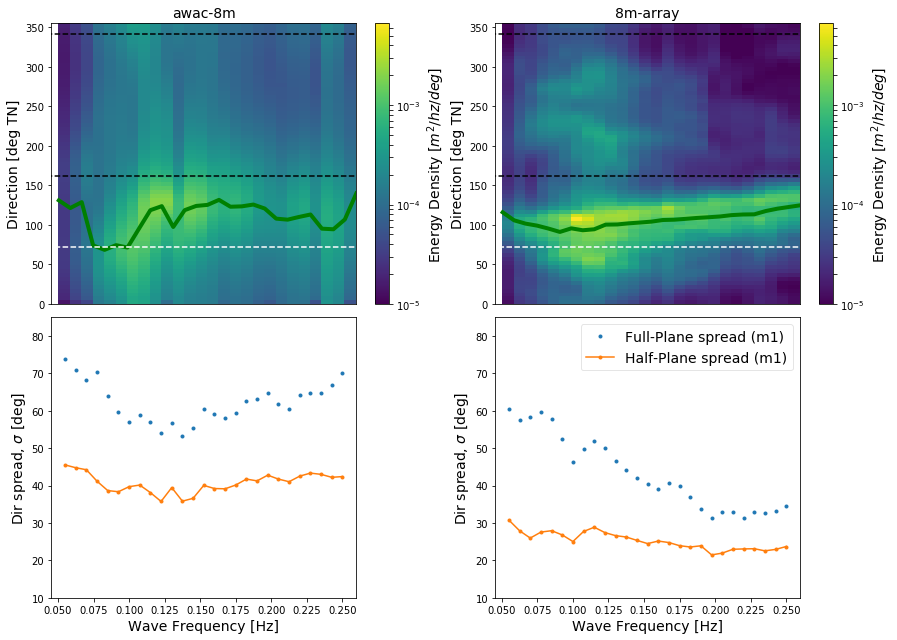

2009-04-06 21:00:00
awac-8m FP H_s: 0.63 [m] D_m 113.25 [deg] $\sigma$ 62.25 .... 8m-array FP H_s: 0.62 [m] D_m: 108.15 [deg] $\sigma$ 45.71
awac-8m HP H_s: 0.52 [m] D_m 93.29 [deg] $\sigma$ 40.39 .....8m-array HP H_s: 0.57 [m] D_m: 102.20 [deg] $\sigma$ 27.59

HP diff    H_s: 0.11 [m] D_m 19.96 [deg] $\sigma$ 21.86 ......        H_s: 0.05 [m] D_m: 5.94 [deg] $\sigma$ 18.12


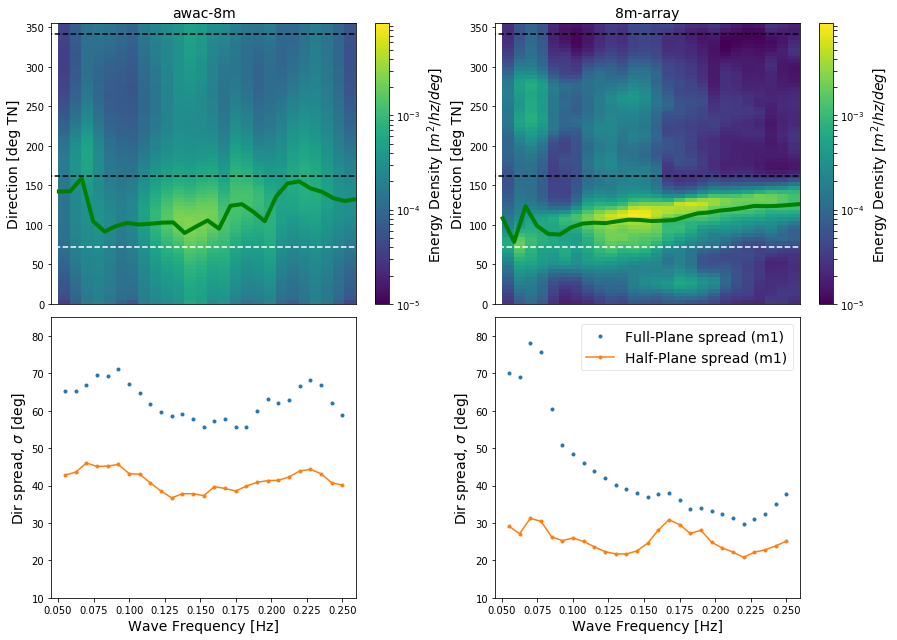

2009-04-07 01:00:00
awac-8m FP H_s: 0.55 [m] D_m 115.62 [deg] $\sigma$ 56.99 .... 8m-array FP H_s: 0.50 [m] D_m: 105.12 [deg] $\sigma$ 42.99
awac-8m HP H_s: 0.47 [m] D_m 98.58 [deg] $\sigma$ 37.22 .....8m-array HP H_s: 0.47 [m] D_m: 100.43 [deg] $\sigma$ 25.52

HP diff    H_s: 0.08 [m] D_m 17.04 [deg] $\sigma$ 19.77 ......        H_s: 0.03 [m] D_m: 4.69 [deg] $\sigma$ 17.47


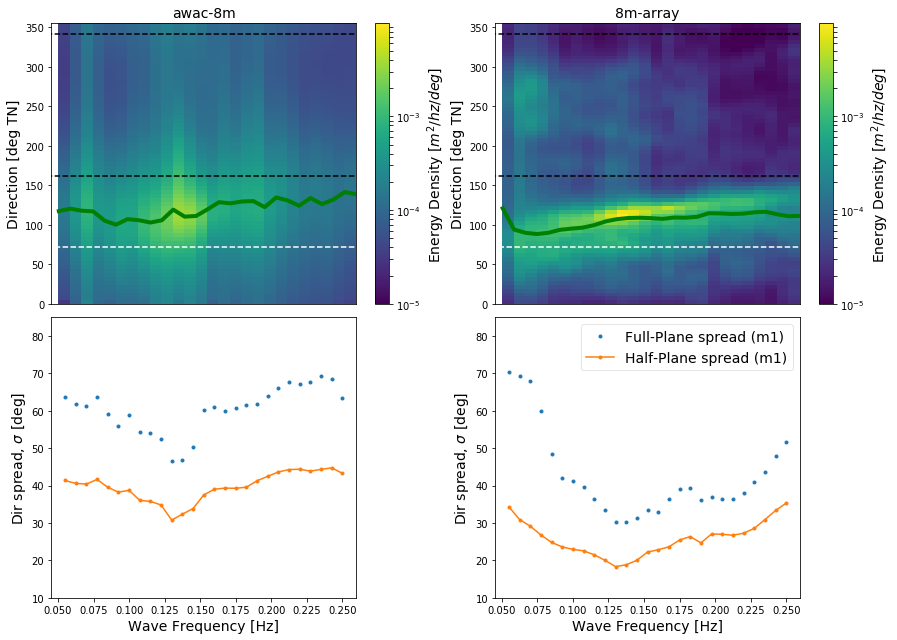

2009-04-07 02:00:00
awac-8m FP H_s: 0.55 [m] D_m 108.64 [deg] $\sigma$ 60.58 .... 8m-array FP H_s: 0.52 [m] D_m: 102.15 [deg] $\sigma$ 44.60
awac-8m HP H_s: 0.47 [m] D_m 93.14 [deg] $\sigma$ 39.31 .....8m-array HP H_s: 0.48 [m] D_m: 97.51 [deg] $\sigma$ 26.78

HP diff    H_s: 0.09 [m] D_m 15.50 [deg] $\sigma$ 21.28 ......        H_s: 0.04 [m] D_m: 4.64 [deg] $\sigma$ 17.83


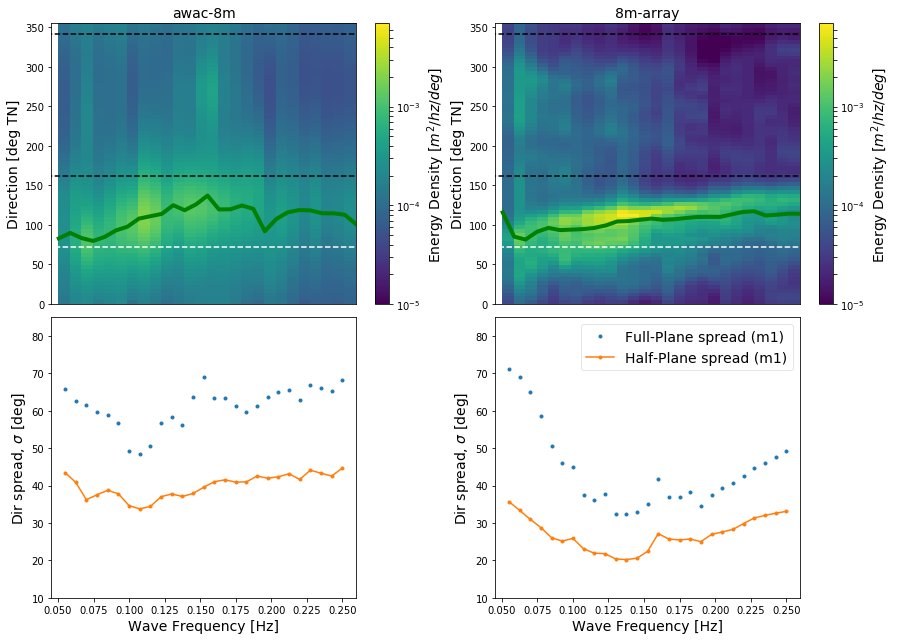

2009-04-07 03:00:00
awac-8m FP H_s: 0.51 [m] D_m 101.99 [deg] $\sigma$ 59.62 .... 8m-array FP H_s: 0.52 [m] D_m: 96.25 [deg] $\sigma$ 43.72
awac-8m HP H_s: 0.44 [m] D_m 89.06 [deg] $\sigma$ 38.60 .....8m-array HP H_s: 0.49 [m] D_m: 92.60 [deg] $\sigma$ 26.73

HP diff    H_s: 0.07 [m] D_m 12.93 [deg] $\sigma$ 21.02 ......        H_s: 0.03 [m] D_m: 3.65 [deg] $\sigma$ 16.99


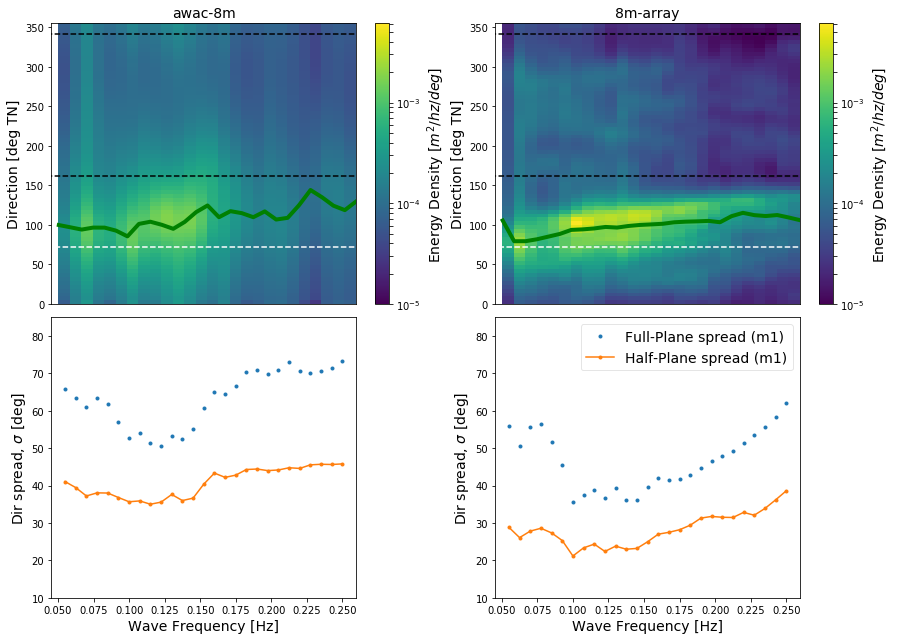

2009-04-07 04:00:00
awac-8m FP H_s: 0.53 [m] D_m 106.13 [deg] $\sigma$ 58.13 .... 8m-array FP H_s: 0.49 [m] D_m: 93.72 [deg] $\sigma$ 44.05
awac-8m HP H_s: 0.45 [m] D_m 93.26 [deg] $\sigma$ 37.26 .....8m-array HP H_s: 0.46 [m] D_m: 90.06 [deg] $\sigma$ 27.32

HP diff    H_s: 0.07 [m] D_m 12.87 [deg] $\sigma$ 20.86 ......        H_s: 0.03 [m] D_m: 3.65 [deg] $\sigma$ 16.72


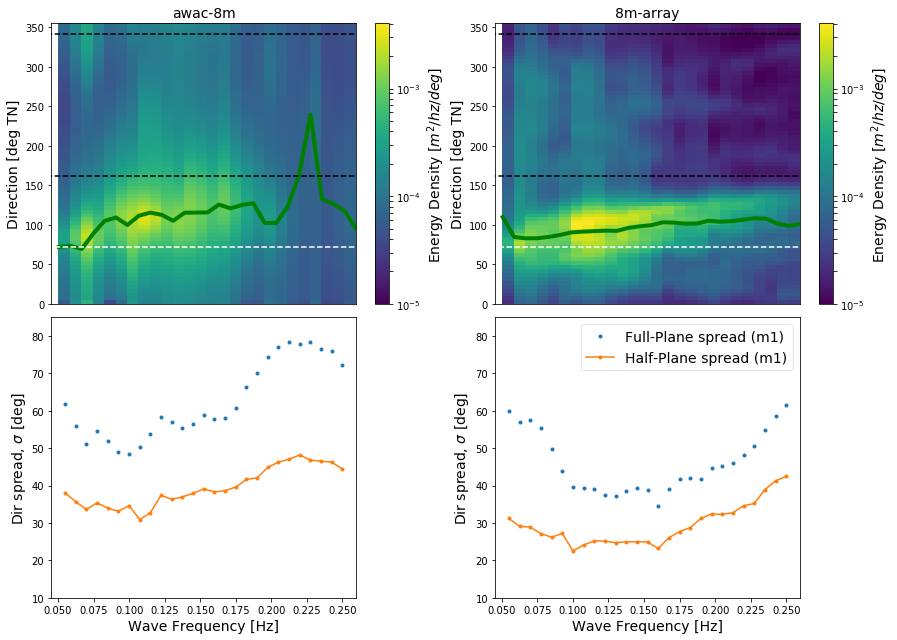

In [111]:
shift = -72
count = 0
for idxOfInterest in idxHighResidual:
    if count > 40:
        continue
    if np.abs(obs_bulkStat_FP['Hm0'][idxOfInterest] - mod_bulkStat_FP['Hm0'][idxOfInterest]) > 0.05:
        continue  # if the wave height difference is greater than 5 cm, keep going 
    count += 1
    vmin = 0.00001           #min(obs_matched['dWED'][idxOfInterest].min(), mod_matched['dWED'][idxOfInterest].min())
    vmax = max(obs_matched['dWED'][idxOfInterest].max(), mod_matched['dWED'][idxOfInterest].max())
    #######################################################
    plt.figure(figsize=(14, 10))
#     plt.suptitle(obs_matched['time'][idxOfInterest])
    ################
    ax1 = plt.subplot(221)
    plt.pcolormesh(obs_matched['wavefreqbin'][idxFreq], obs_matched['wavedirbin'], obs_matched['dWED'][idxOfInterest, idxFreq].T, 
                   norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.title(obslabel, fontsize=fsize)
    plt.plot(obs_matched['wavefreqbin'][idxFreq], np.mod(np.rad2deg(np.arctan2(obs_matched['b1'][idxOfInterest, idxFreq], obs_matched['a1'][idxOfInterest, idxFreq])), 360), 'g', lw=4)
#     plt.plot(obs_matched['wavefreqbin'][idxFreq], np.mod(np.rad2deg(np.arctan2(obs_matched['b2'][idxOfInterest, idxFreq], obs_matched['a2'][idxOfInterest, idxFreq]))+shift, 360), 'C2', lw=4)
    plt.plot([0, 0.5], [72, 72], 'w--')
    plt.plot([0, 0.5], [162, 162], 'k--')
    plt.plot([0, 0.5], [342, 342], 'k--')
    plt.xlim([0.05,  HFcutoff])
    cbar = plt.colorbar()
    cbar.set_label('Energy Density $[m^2/hz/deg]$', fontsize=fsize)
    plt.ylabel('Direction [deg TN]', fontsize=fsize)
#     plt.xlabel('Wave Frequency [Hz]')
    plt.tick_params(axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)
    ################
    ax2 = plt.subplot(222)
    plt.title(modlabel, fontsize=fsize)
    plt.pcolormesh(mod_matched['wavefreqbin'][idxFreq], mod_matched['wavedirbin'], mod_matched['dWED'][idxOfInterest, idxFreq].T,
                   norm=LogNorm(vmin=vmin, vmax=vmax))
    plt.plot(mod_matched['wavefreqbin'][idxFreq], np.mod(np.rad2deg(np.arctan2(mod_matched['b1'][idxOfInterest, idxFreq], mod_matched['a1'][idxOfInterest, idxFreq])), 360), 'g', lw=4)
#     plt.plot(mod_matched['wavefreqbin'][idxFreq], np.mod(np.rad2deg(np.arctan2(mod_matched['b2'][idxOfInterest, idxFreq], mod_matched['a2'][idxOfInterest, idxFreq]))+shift, 360), 'C2', lw=4)

    plt.plot([0, 0.5], [72, 72], 'w--')
    plt.plot([0, 0.5], [162, 162], 'k--')
    plt.plot([0, 0.5], [342, 342], 'k--')
    plt.xlim([0.05, HFcutoff])
    cbar = plt.colorbar()
    cbar.set_label('Energy Density $[m^2/hz/deg]$', fontsize=fsize)
    plt.ylabel('Direction [deg TN]', fontsize=fsize)
#     plt.xlabel('Wave Frequency [Hz]')
    plt.tick_params(axis='x',  # changes apply to the x-axis
                which='both',  # both major and minor ticks are affected
                bottom=False,  # ticks along the bottom edge are off
                top=False,  # ticks along the top edge are off
                labelbottom=False)
    ################
    ax3 = plt.subplot(223)
    plt.plot(obs_matched['wavefreqbin'][idxFreq], obs_bulkStat_FP['spreadDP_m1'][idxOfInterest], '.', label='Full-Plane spread (m1)')
    plt.plot(obs_matched['wavefreqbin'][idxFreq], obs_bulkStat_HP['spreadDP_m1'][idxOfInterest], '.-', label='Half-Plane spread (m1)')
#     plt.plot(obs_matched['wavefreqbin'][idxFreq], obs_bulkStat_FP['spreadDP_m2'][idxOfInterest], '.', label='Full-Plane spread (m2)')
#     plt.plot(obs_matched['wavefreqbin'][idxFreq], obs_bulkStat_HP['spreadDP_m2'][idxOfInterest], '.-', label='Half-Plane spread (m2)')
    plt.ylim([10,85])
    plt.xlabel('Wave Frequency [Hz]', fontsize=fsize)
    plt.ylabel('Dir spread, $\sigma$ [deg]', fontsize=fsize)
    ################
    ax4 = plt.subplot(224)
    plt.plot(obs_matched['wavefreqbin'][idxFreq], mod_bulkStat_FP['spreadDP_m1'][idxOfInterest], '.', label='Full-Plane spread (m1)')
    plt.plot(obs_matched['wavefreqbin'][idxFreq], mod_bulkStat_HP['spreadDP_m1'][idxOfInterest], '.-', label='Half-Plane spread (m1)')
#     plt.plot(obs_matched['wavefreqbin'][idxFreq], mod_bulkStat_FP['spreadDP_m2'][idxOfInterest], '.', label='Full-Plane spread (m2)')
#     plt.plot(obs_matched['wavefreqbin'][idxFreq], mod_bulkStat_HP['spreadDP_m2'][idxOfInterest], '.-', label='Half-Plane spread (m2)')
    plt.ylim([10,85])
    plt.xlabel('Wave Frequency [Hz]', fontsize=fsize)
    plt.ylabel('Dir spread, $\sigma$ [deg]', fontsize=fsize)
    plt.legend(fancybox=True, framealpha=0.5, fontsize=fsize)
    plt.tight_layout(w_pad=0.21, h_pad=0.2, rect=[0.05, 0.05, 0.95, 0.95])
    ########## adjust bottom plots #############################
    pos1 = ax1.get_position()
    pos2 = ax2.get_position()
    pos3 = ax3.get_position()
    pos4 = ax4.get_position()
    pos3new = [pos3.x0, pos3.y0, pos1.width,  pos3.height]
    pos4new = [pos4.x0, pos4.y0, pos2.width,  pos4.height]
    ax4.set_position(pos4new)
    ax3.set_position(pos3new)
    ##############make print statements #########################
    print(obs_matched['time'][idxOfInterest])
    print('{} FP H_s: {:.2f} [m] D_m {:.2f} [deg] $\sigma$ {:.2f} .... {} FP H_s: {:.2f} [m] D_m: {:.2f} [deg] $\sigma$ {:.2f}'.format(obslabel, obs_bulkStat_FP['Hm0'][idxOfInterest], obs_bulkStat_FP['Dm'][idxOfInterest], obs_bulkStat_FP['spreadD'][idxOfInterest], modlabel, mod_bulkStat_FP['Hm0'][idxOfInterest], mod_bulkStat_FP['Dm'][idxOfInterest], mod_bulkStat_FP['spreadD'][idxOfInterest]))
    print('{} HP H_s: {:.2f} [m] D_m {:.2f} [deg] $\sigma$ {:.2f} .....{} HP H_s: {:.2f} [m] D_m: {:.2f} [deg] $\sigma$ {:.2f}'.format(obslabel, obs_bulkStat_HP['Hm0'][idxOfInterest], obs_bulkStat_HP['Dm'][idxOfInterest], obs_bulkStat_HP['spreadD'][idxOfInterest], modlabel, mod_bulkStat_HP['Hm0'][idxOfInterest], mod_bulkStat_HP['Dm'][idxOfInterest], mod_bulkStat_HP['spreadD'][idxOfInterest]))
    print('\nHP diff    H_s: {:.2f} [m] D_m {:.2f} [deg] $\sigma$ {:.2f} ......        H_s: {:.2f} [m] D_m: {:.2f} [deg] $\sigma$ {:.2f}'.format((obs_bulkStat_FP['Hm0'][idxOfInterest] - obs_bulkStat_HP['Hm0'][idxOfInterest]), (obs_bulkStat_FP['Dm'][idxOfInterest] - obs_bulkStat_HP['Dm'][idxOfInterest]), (obs_bulkStat_FP['spreadD'][idxOfInterest] - obs_bulkStat_HP['spreadD'][idxOfInterest]), (mod_bulkStat_FP['Hm0'][idxOfInterest] - mod_bulkStat_HP['Hm0'][idxOfInterest]), (mod_bulkStat_FP['Dm'][idxOfInterest] - mod_bulkStat_HP['Dm'][idxOfInterest]), (mod_bulkStat_FP['spreadD'][idxOfInterest] - mod_bulkStat_HP['spreadD'][idxOfInterest])  ))

    plt.show()
